# Regime-Aware Reinforcement Learning for Fixed Income Portfolio Management

This notebook demonstrates the complete workflow for the fixed income RL project, from data loading to backtesting. We'll cover:

1. **Data Loading and Processing**: Fetch and prepare fixed income data
2. **Regime Detection**: Identify interest rate and credit regimes
3. **Bond Market Simulation**: Create a synthetic bond universe and simulate market dynamics
4. **GNN for Credit Risk**: Model credit risk propagation through issuer networks
5. **RL Environment Setup**: Create the fixed income portfolio management environment
6. **RL Agent Training**: Train the agent to optimize portfolio allocation
7. **Backtesting and Evaluation**: Evaluate strategy performance against benchmarks

## 0. Setup and Imports

First, we'll import the necessary modules and set up logging.

In [1]:
"""
This cell does: 
1. Imports the necessary modules
2. Sets up logging
"""
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import logging
import time

# Add the project root to the path
sys.path.append(os.path.abspath('..'))

# Configure logging by creating a logger object. This is used to log messages to the console.
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [2]:
# Create necessary directories
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../output/models', exist_ok=True)
os.makedirs('../output/plots', exist_ok=True)
os.makedirs('../output/results', exist_ok=True)

## 1. Data Loading and Processing

We'll start by loading fixed income data using the `FixedIncomeDataLoader` class. This includes:

- US Treasury yield curve data
- Corporate bond indices
- Macroeconomic indicators
- Bond ETF data



In [3]:
from src.data.data_loader import FixedIncomeDataLoader
from src.data.data_processor import FixedIncomeDataProcessor
from src.data.data_utils import save_dataframe, save_pickle

fred_api_key = os.environ.get('FRED_API_KEY', None)
quandl_api_key = os.environ.get('QUANDL_API_KEY', None)

# Create data loader
data_loader = FixedIncomeDataLoader(
    fred_api_key=fred_api_key,
    quandl_api_key=quandl_api_key
)

In [4]:
# Define date range
start_date = '2010-02-01'
end_date = '2024-12-31'

try:
    raw_data = data_loader.load_all_data(
            start_date=start_date,
            end_date=end_date,
            save=True
    )

    print("Data loaded successfully!")
    print(f"Data types: {list(raw_data.keys())}")

    # Print data summary
    for key, df in raw_data.items():
        if isinstance(df, pd.DataFrame):
            print(f"\n{key}: {df.shape} - {df.index[0]} to {df.index[-1]}")
except Exception as e:

    print(f"Error loading data: {e}")
# Load all data
#try:


    print("Generating synthetic data for demonstration purposes...")

    # Generate synthetic yield curve data
    dates = pd.date_range(start=start_date, end=end_date, freq='B')

    # Treasury yields
    tenors = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
    base_rates = [0.5, 0.6, 0.7, 0.9, 1.2, 1.5, 1.8, 2.0, 2.2, 2.5, 2.7]

    # Generate random walk for rates
    np.random.seed(42)
    n_days = len(dates)
    n_tenors = len(tenors)

    # Principal components for yield curve (level, slope, curvature)
    pc1 = np.cumsum(np.random.normal(0, 0.01, n_days))  # Level
    pc2 = np.cumsum(np.random.normal(0, 0.005, n_days))  # Slope
    pc3 = np.cumsum(np.random.normal(0, 0.002, n_days))  # Curvature

    # Create yield curves
    yields_data = {}
    for i, tenor in enumerate(tenors):
        # Different impact of PCs based on tenor
        level_impact = 1.0
        slope_impact = -1.0 + 2.0 * i / (n_tenors - 1)  # -1 to 1
        curvature_impact = -1.0 + 2.0 * (i / (n_tenors - 1) - 0.5) ** 2 * 4  # Quadratic
        
        # Generate yields
        yields = base_rates[i] + level_impact * pc1 + slope_impact * pc2 + curvature_impact * pc3
        yields = np.maximum(yields, 0.01)  # Ensure positive yields
        yields_data[tenor] = yields

    # Create DataFrame
    yields_df = pd.DataFrame(yields_data, index=dates)

    # Add spread columns
    yields_df['2s10s_spread'] = yields_df['10Y'] - yields_df['2Y']
    yields_df['3m30y_spread'] = yields_df['30Y'] - yields_df['3M']

    # Add curve factors
    yields_df['level'] = (yields_df['2Y'] + yields_df['5Y'] + yields_df['10Y']) / 3
    yields_df['slope'] = yields_df['10Y'] - yields_df['2Y']
    yields_df['curvature'] = 2 * yields_df['5Y'] - yields_df['2Y'] - yields_df['10Y']

    # Create corporate bond data
    corp_data = {}

    # AAA and BAA yields
    corp_data['AAA'] = yields_df['10Y'] + np.maximum(0.5 + pc1 * 0.2 + np.random.normal(0, 0.01, n_days), 0.1)
    corp_data['BAA'] = yields_df['10Y'] + np.maximum(1.2 + pc1 * 0.3 + pc2 * 0.2 + np.random.normal(0, 0.02, n_days), 0.3)

    # Spreads
    corp_data['AAA_10Y_spread'] = corp_data['AAA'] - yields_df['10Y']
    corp_data['BAA_10Y_spread'] = corp_data['BAA'] - yields_df['10Y']
    corp_data['AAA_BAA_spread'] = corp_data['BAA'] - corp_data['AAA']

    # Create DataFrame
    corp_df = pd.DataFrame(corp_data, index=dates)

    # Create synthetic bond ETF data
    etf_tickers = ['IEF', 'TLT', 'SHY', 'LQD', 'HYG', 'JNK', 'MUB']
    etf_prices = {}

    for ticker in etf_tickers:
        # Start with random price
        price = 100.0
        prices = [price]
        
        # Generate price series
        for i in range(1, n_days):
            # Price change depends on yield changes
            if 'TLT' in ticker:  # Long-term Treasury
                factor = -15.0  # High duration
                yield_change = yields_df['30Y'].iloc[i] - yields_df['30Y'].iloc[i-1]
            elif 'IEF' in ticker:  # Intermediate Treasury
                factor = -7.0  # Medium duration
                yield_change = yields_df['7Y'].iloc[i] - yields_df['7Y'].iloc[i-1]
            elif 'SHY' in ticker:  # Short-term Treasury
                factor = -2.0  # Low duration
                yield_change = yields_df['2Y'].iloc[i] - yields_df['2Y'].iloc[i-1]
            elif 'LQD' in ticker:  # Investment Grade Corporate
                factor = -8.0  # Medium-high duration
                yield_change = corp_df['AAA'].iloc[i] - corp_df['AAA'].iloc[i-1]
            elif 'HYG' in ticker or 'JNK' in ticker:  # High Yield
                factor = -4.0  # Medium-low duration
                yield_change = corp_df['BAA'].iloc[i] - corp_df['BAA'].iloc[i-1]
            elif 'MUB' in ticker:  # Municipal
                factor = -6.0  # Medium duration
                yield_change = yields_df['10Y'].iloc[i] - yields_df['10Y'].iloc[i-1]
            else:
                factor = -5.0  # Default
                yield_change = yields_df['5Y'].iloc[i] - yields_df['5Y'].iloc[i-1]
            
            # Calculate price change
            price_change = factor * yield_change * 100 + np.random.normal(0, 0.1)
            price = price * (1 + price_change / 100)
            prices.append(price)
        
        etf_prices[f'price_{ticker}'] = prices

    # Create DataFrame
    etf_df = pd.DataFrame(etf_prices, index=dates)

    # Create package of synthetic data
    raw_data = {
        'yields': yields_df,
        'corporate': corp_df,
        'etfs': etf_df
    }

    # Save synthetic data
    for key, df in raw_data.items():
        df.to_csv(f'../data/raw/{key}.csv')

    print("Synthetic data generated successfully!")
    print(f"Data types: {list(raw_data.keys())}")

# Print data summary
for key, df in raw_data.items():
    print(f"\n{key}: {df.shape} - {df.index[0]} to {df.index[-1]}")

2025-03-21 22:03:45,953 - src.data.data_loader - INFO - Loading all data from 2010-02-01 to 2024-12-31
2025-03-21 22:03:45,953 - src.data.data_loader - INFO - Fetching Treasury yields from 2010-02-01 to 2024-12-31
2025-03-21 22:03:50,504 - src.data.data_loader - INFO - Successfully fetched yield data with shape (3892, 16)
2025-03-21 22:03:50,527 - src.data.data_loader - INFO - Saved data to data/raw/treasury_yields.csv
2025-03-21 22:03:50,527 - src.data.data_loader - INFO - Fetching corporate bond indices from 2010-02-01 to 2024-12-31
2025-03-21 22:03:52,463 - src.data.data_loader - INFO - Successfully fetched corporate bond indices with shape (3942, 6)
2025-03-21 22:03:52,472 - src.data.data_loader - INFO - Saved data to data/raw/corporate_bonds.csv
2025-03-21 22:03:52,473 - src.data.data_loader - INFO - Fetching macroeconomic indicators from 2010-02-01 to 2024-12-31
/Users/ranystephan/Desktop/RIFLE/src/data/data_loader.py:223: FutureWarning: The default fill_method='pad' in Series.pc

YF.download() has changed argument auto_adjust default to True


2025-03-21 22:03:54,849 - src.data.data_loader - INFO - Using Close prices for IEF
2025-03-21 22:03:55,090 - src.data.data_loader - INFO - Using Close prices for TLT
2025-03-21 22:03:55,295 - src.data.data_loader - INFO - Using Close prices for SHY
2025-03-21 22:03:55,521 - src.data.data_loader - INFO - Using Close prices for LQD
2025-03-21 22:03:55,703 - src.data.data_loader - INFO - Using Close prices for VCIT
2025-03-21 22:03:55,935 - src.data.data_loader - INFO - Using Close prices for VCSH
2025-03-21 22:03:56,129 - src.data.data_loader - INFO - Using Close prices for HYG
2025-03-21 22:03:56,337 - src.data.data_loader - INFO - Using Close prices for JNK
2025-03-21 22:03:56,521 - src.data.data_loader - INFO - Using Close prices for MUB
2025-03-21 22:03:56,713 - src.data.data_loader - INFO - Using Close prices for TFI
2025-03-21 22:03:56,883 - src.data.data_loader - INFO - Using Close prices for BNDX
2025-03-21 22:03:57,071 - src.data.data_loader - INFO - Using Close prices for EMB
2

Data loaded successfully!
Data types: ['yields', 'corporate', 'macro', 'etfs', 'issuer_nodes', 'issuer_edges']

yields: (3892, 16) - 2010-02-01 00:00:00 to 2024-12-31 00:00:00

corporate: (3942, 6) - 2010-02-01 00:00:00 to 2024-12-31 00:00:00

macro: (3943, 11) - 2010-01-01 00:00:00 to 2024-12-31 00:00:00

etfs: (3754, 36) - 2010-02-01 00:00:00 to 2024-12-30 00:00:00

issuer_nodes: (503, 4) - MMM to ZTS

issuer_edges: (2678, 4) - 0 to 2677

yields: (3892, 16) - 2010-02-01 00:00:00 to 2024-12-31 00:00:00

corporate: (3942, 6) - 2010-02-01 00:00:00 to 2024-12-31 00:00:00

macro: (3943, 11) - 2010-01-01 00:00:00 to 2024-12-31 00:00:00

etfs: (3754, 36) - 2010-02-01 00:00:00 to 2024-12-30 00:00:00

issuer_nodes: (503, 4) - MMM to ZTS

issuer_edges: (2678, 4) - 0 to 2677


In [5]:
raw_data

{'yields':               1M    3M    6M    1Y    2Y    3Y    5Y    7Y   10Y   20Y   30Y  \
 2010-02-01  0.05  0.10  0.17  0.33  0.86  1.41  2.38  3.12  3.68  4.43  4.56   
 2010-02-02  0.04  0.10  0.17  0.33  0.86  1.41  2.37  3.11  3.67  4.42  4.55   
 2010-02-03  0.05  0.10  0.17  0.35  0.88  1.44  2.40  3.16  3.73  4.49  4.62   
 2010-02-04  0.04  0.09  0.16  0.32  0.80  1.34  2.29  3.06  3.62  4.39  4.53   
 2010-02-05  0.03  0.10  0.17  0.31  0.77  1.28  2.23  3.00  3.59  4.36  4.51   
 ...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
 2024-12-25  4.44  4.40  4.30  4.24  4.29  4.36  4.43  4.52  4.59  4.84  4.76   
 2024-12-26  4.45  4.35  4.31  4.23  4.30  4.35  4.42  4.49  4.58  4.83  4.76   
 2024-12-27  4.44  4.31  4.29  4.20  4.31  4.36  4.45  4.53  4.62  4.89  4.82   
 2024-12-30  4.43  4.37  4.25  4.17  4.24  4.29  4.37  4.46  4.55  4.84  4.77   
 2024-12-31  4.40  4.37  4.24  4.16  4.25  4.27  4.38  4.48  4.58  4.86  4.78   
 
             2s1

In [6]:
raw_data['macro']['Inflation_YoY'].to_csv('Inflation_YoY.csv')

### 1.1 Data Processing and Feature Engineering

Now we'll process the raw data to create features for our models.

In [7]:
# Create data processor
data_processor = FixedIncomeDataProcessor()

# Process data
processed_data = data_processor.process_data_pipeline(
    data_dict=raw_data,
    for_regime=True,
    for_rl=True,
    n_lags=10
)

print("Data processed successfully!")
print(f"Processed data keys: {list(processed_data.keys())}")

2025-03-21 22:03:57,464 - src.data.data_processor - INFO - Running complete data processing pipeline
2025-03-21 22:03:57,467 - src.data.data_processor - INFO - issuer_nodes: Identified as static data, skipping alignment
2025-03-21 22:03:57,468 - src.data.data_processor - WARNING - issuer_edges: Found 2678 suspicious dates from 1970 (Unix epoch)
2025-03-21 22:03:57,469 - src.data.data_processor - INFO - issuer_edges: Using earliest date from other datasets: 2010-01-01 00:00:00
2025-03-21 22:03:57,480 - src.data.data_processor - INFO - issuer_edges: Reconstructed date index from 2010-01-01 00:00:00 to 2020-04-07 00:00:00
2025-03-21 22:03:57,480 - src.data.data_processor - INFO - Consensus date range across datasets: 2010-01-01 00:00:00 to 2024-12-31 00:00:00
2025-03-21 22:03:57,481 - src.data.data_processor - INFO - Aligning datasets to a common date index
2025-03-21 22:03:57,482 - src.data.data_processor - INFO - issuer_nodes: Identified as static data, skipping alignment
2025-03-21 22:

Data processed successfully!
Processed data keys: ['processed', 'regime_features', 'regime_features_normalized', 'regime_train', 'regime_val', 'regime_test', 'rl_features', 'rl_features_normalized', 'rl_train', 'rl_val', 'rl_test']


Processed data keys: ['processed', 'regime_features', 'regime_features_normalized', 'regime_train', 'regime_val', 'regime_test', 'rl_features', 'rl_features_normalized', 'rl_train', 'rl_val', 'rl_test']


In [8]:
processed_data["regime_features"].columns

Index(['2Y_yield', '5Y_yield', '10Y_yield', '30Y_yield', '2s10s_spread',
       '2s10s_zscore', '3m10y_spread', 'curve_level', 'curve_slope',
       'curve_curvature', '2Y_1m_change', '2Y_3m_change', '5Y_1m_change',
       '5Y_3m_change', '10Y_1m_change', '10Y_3m_change', '30Y_1m_change',
       '30Y_3m_change', '2Y_volatility', '5Y_volatility', '10Y_volatility',
       '30Y_volatility', 'credit_spread', 'credit_spread_zscore',
       'credit_spread_1m_change', 'credit_spread_3m_change',
       'credit_spread_volatility', 'vix', 'vix_zscore', 'inflation',
       'inflation_zscore'],
      dtype='object')

Regime detection features: (2303, 31)
Feature columns: ['2Y_yield', '5Y_yield', '10Y_yield', '30Y_yield', '2s10s_spread', '2s10s_zscore', '3m10y_spread', 'curve_level', 'curve_slope', 'curve_curvature']...


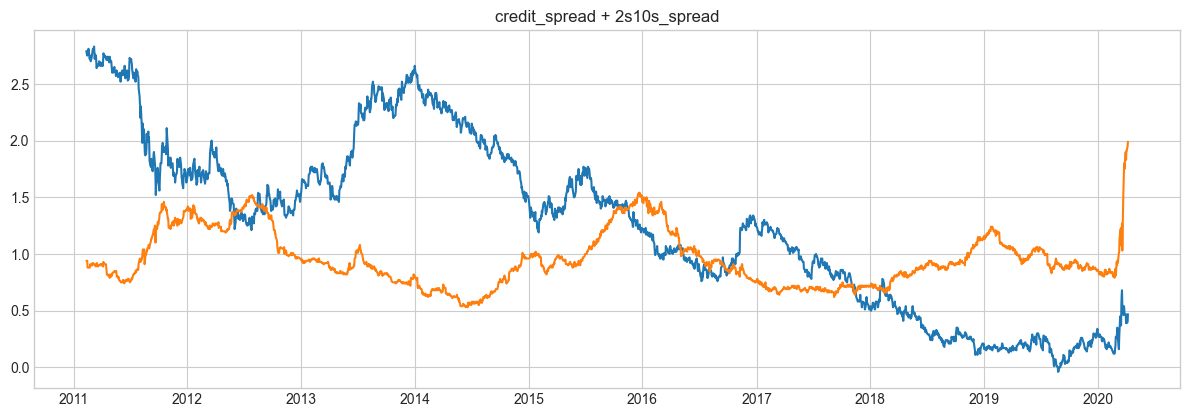

In [9]:
# Explore the processed data
regime_features = processed_data['regime_features']
print(f"Regime detection features: {regime_features.shape}")
print(f"Feature columns: {regime_features.columns.tolist()[:10]}...")

# Plot some key features
plt.figure(figsize=(12, 8))


    
if '2s10s_spread' in regime_features.columns:
    plt.subplot(2, 1, 1)
    plt.plot(regime_features['2s10s_spread'])
    plt.title('2s10s Spread')
    plt.grid(True)
    
if 'credit_spread' in regime_features.columns:
    plt.subplot(2, 1, 1)
    plt.plot(regime_features['credit_spread'])
    plt.title('credit_spread + 2s10s_spread')
    plt.grid(True)



plt.tight_layout()
plt.show()

## 2. Regime Detection

Now, we'll use unsupervised learning to identify distinct market regimes based on interest rates, yield curve shape, and credit spreads.

In [10]:
from src.models.regime_detection import FixedIncomeRegimeDetector

# Create regime detector
n_regimes = 4
regime_detector = FixedIncomeRegimeDetector(
    n_regimes=n_regimes,
    model_type='hmm',  # Hidden Markov Model
    random_state=42
)

# Fit the model
print(f"Fitting HMM model with {n_regimes} regimes...")
regime_labels = regime_detector.fit(regime_features)


# Create regime DataFrame
regime_df = pd.DataFrame({'regime': regime_labels}, index=regime_features.index)

# Get transition matrix
transitions = regime_detector.get_regime_transitions(regime_df)
print("\nRegime transition probabilities:")
print(transitions)

2025-03-21 22:03:57,967 - src.models.regime_detection - INFO - Fitting hmm model with 4 regimes
2025-03-21 22:03:57,971 - src.models.regime_detection - INFO - Feature shape before handling missing values: (2303, 31)
2025-03-21 22:03:57,973 - src.models.regime_detection - INFO - Reduced dimensions from 31 to 10
2025-03-21 22:03:57,973 - src.models.regime_detection - INFO - Explained variance ratio: [0.29871216 0.16857888 0.12345052 0.08657829 0.08249922 0.05876617
 0.0388934  0.02836037 0.02490964 0.02260876]
2025-03-21 22:03:58,119 - src.models.regime_detection - INFO - Model fitted successfully
2025-03-21 22:03:58,121 - src.models.regime_detection - INFO - Calculating regime transitions


Fitting HMM model with 4 regimes...

Regime transition probabilities:
          Regime 0  Regime 1  Regime 2  Regime 3
Regime 0  0.994924  0.002538  0.001269  0.001269
Regime 1  0.002967  0.994065  0.002967  0.000000
Regime 2  0.002205  0.000000  0.997795  0.000000
Regime 3  0.000000  0.003704  0.000000  0.996296


In [11]:
# Name regimes
yields_df = processed_data['processed']['yields']
corporate_df = processed_data['processed'].get('corporate', None)

regime_names = regime_detector.name_regimes(regime_df, yields_df, corporate_df)
print("\nDetected regimes:")
for regime, name in regime_names.items():
    print(f"Regime {regime}: {name}")

# Get regime statistics
etf_df = processed_data['processed'].get('etf_features', None)
stats_df = regime_detector.get_regime_statistics(regime_df, yields_df, corporate_df, etf_df)
print("\nRegime statistics:")
print(stats_df)

2025-03-21 22:03:58,126 - src.models.regime_detection - INFO - Naming regimes
2025-03-21 22:03:58,127 - src.models.regime_detection - INFO - Validating date indices before naming regimes
2025-03-21 22:03:58,127 - src.models.regime_detection - INFO - Validating regime_df with 2303 rows
2025-03-21 22:03:58,128 - src.models.regime_detection - INFO - regime_df has valid start date: 2011-02-11 00:00:00
2025-03-21 22:03:58,128 - src.models.regime_detection - INFO - regime_df has valid end date: 2020-04-07 00:00:00
2025-03-21 22:03:58,128 - src.models.regime_detection - INFO - Validating yields_df with 2313 rows
2025-03-21 22:03:58,129 - src.models.regime_detection - INFO - yields_df has valid start date: 2011-01-28 00:00:00
2025-03-21 22:03:58,129 - src.models.regime_detection - INFO - yields_df has valid end date: 2020-04-07 00:00:00
2025-03-21 22:03:58,129 - src.models.regime_detection - INFO - Validating corporate_df with 2313 rows
2025-03-21 22:03:58,130 - src.models.regime_detection - I


Detected regimes:
Regime Regime 0: Growth: Moderate-Yield/Steep-Curve/Normal-Spread
Regime Regime 1: Recession: Moderate-Yield/Normal-Curve/Normal-Spread
Regime Regime 2: Recovery: Moderate-Yield/Normal-Curve/Normal-Spread
Regime Regime 3: Crisis: Moderate-Yield/Flat-Curve/Normal-Spread

Regime statistics:
         duration_days occurrence_pct  \
Regime 0          3282       34.21624   
Regime 1          3162      14.676509   
Regime 2          1815      39.383413   
Regime 3           392      11.723838   

                                                    summary    avg_2Y  \
Regime 0  Moderate Yields, Steep Curve, Moderate Credit ...  0.811168   
Regime 1  Low-Moderate Yields, Normal Curve, Moderate Cr...  1.530858   
Regime 2   Low Yields, Steep Curve, Moderate Credit Spreads  0.522591   
Regime 3  Moderate Yields, Flat Curve, Moderate Credit S...  2.447185   

            std_2Y    avg_5Y    std_5Y   avg_10Y   std_10Y   avg_30Y  \
Regime 0  0.471578  1.709086  0.242823  2.56015

2025-03-21 22:03:58,150 - src.models.regime_detection - INFO - Plotting regimes
2025-03-21 22:03:58,150 - src.models.regime_detection - INFO - Validating date indices before plotting
2025-03-21 22:03:58,151 - src.models.regime_detection - INFO - Validating regime_df with 2303 rows
2025-03-21 22:03:58,151 - src.models.regime_detection - INFO - regime_df has valid start date: 2011-02-11 00:00:00
2025-03-21 22:03:58,152 - src.models.regime_detection - INFO - regime_df has valid end date: 2020-04-07 00:00:00
2025-03-21 22:03:58,152 - src.models.regime_detection - INFO - Validating yields_df with 2313 rows
2025-03-21 22:03:58,152 - src.models.regime_detection - INFO - yields_df has valid start date: 2011-01-28 00:00:00
2025-03-21 22:03:58,153 - src.models.regime_detection - INFO - yields_df has valid end date: 2020-04-07 00:00:00
2025-03-21 22:03:58,153 - src.models.regime_detection - INFO - Validating corporate_df with 2313 rows
2025-03-21 22:03:58,153 - src.models.regime_detection - INFO 

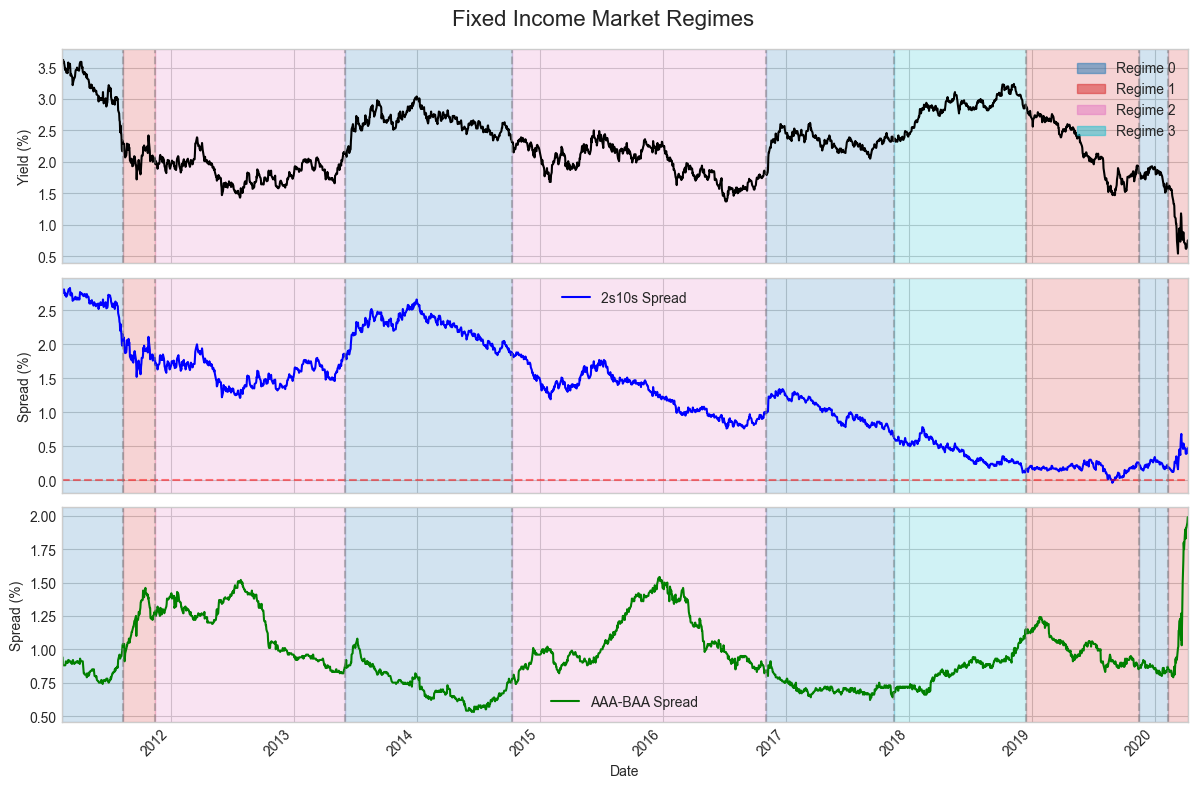

2025-03-21 22:03:58,453 - src.models.regime_detection - INFO - Plotting regime characteristics
2025-03-21 22:03:58,474 - src.models.regime_detection - WARNING - No ETF return data found in regime statistics. This may indicate that ETF data wasn't properly processed.
2025-03-21 22:03:58,474 - src.models.regime_detection - INFO - Look at the 'etf_df' parameter passed to get_regime_statistics to ensure ETF data is available.


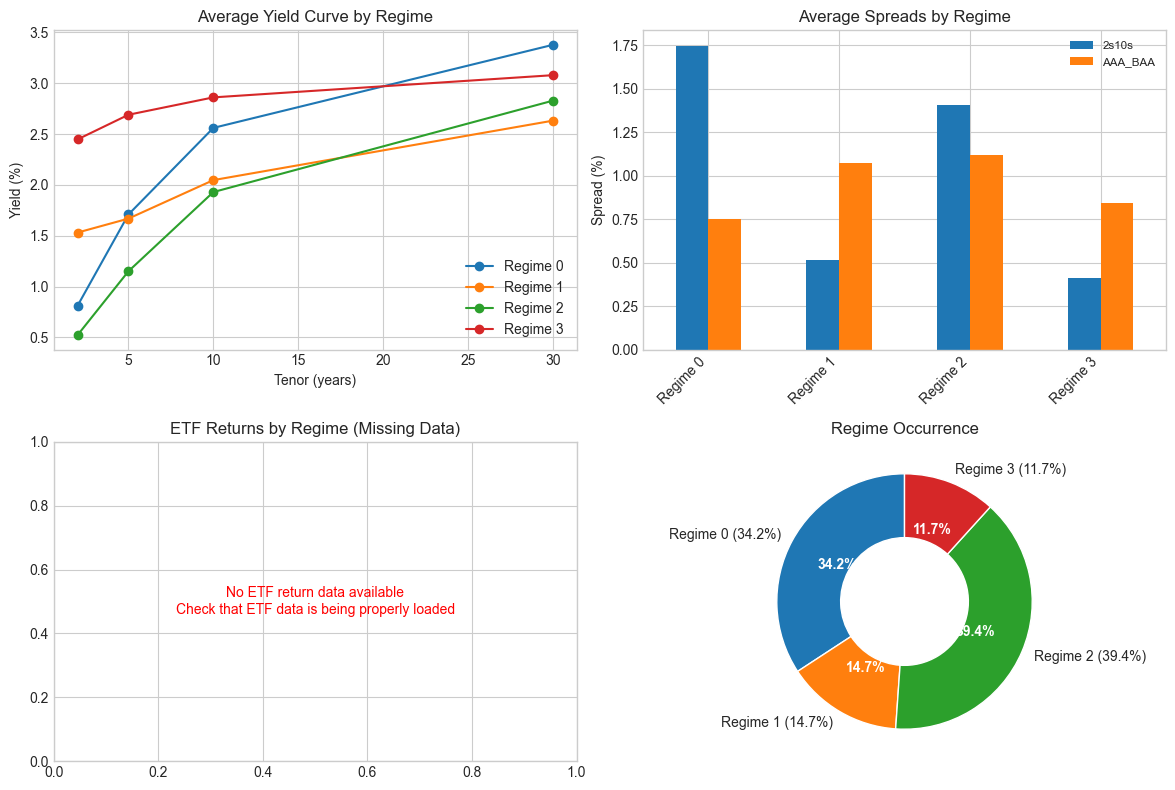

In [12]:
# Plot regimes
fig = regime_detector.plot_regimes(regime_df, yields_df, corporate_df)
plt.show()

# Plot regime characteristics
fig = regime_detector.plot_regime_characteristics(stats_df)
plt.show()

## 3. Bond Market Simulation

Next, we'll create a synthetic bond universe and simulate market dynamics with regime-dependent behavior.

In [13]:
from src.models.bond_market import BondMarketSimulator, InterestRateModel, CreditSpreadModel

# Create bond market simulator
simulator = BondMarketSimulator(random_state=43)

# Create bond universe
n_bonds = 10  # Use a smaller number for demonstration
print(f"Creating synthetic bond universe with {n_bonds} bonds...")
bond_universe = simulator.create_bond_universe(n_bonds=n_bonds)

# Display sample bonds
print("\nSample bonds:")
print(bond_universe)

2025-03-21 22:03:58,614 - src.models.bond_market - INFO - Creating realistic bond universe with 10 bonds
2025-03-21 22:03:58,615 - src.models.bond_market - INFO - Created bond universe with 10 bonds


Creating synthetic bond universe with 10 bonds...

Sample bonds:
         id  face_value  coupon_rate  time_to_maturity rating  \
0  BOND0000      1000.0     0.036317          1.481179     AA   
1  BOND0001      1000.0     0.033941          2.467497    BBB   
2  BOND0002      1000.0     0.016991         18.315435      A   
3  BOND0003      1000.0     0.044513         14.771721    AAA   
4  BOND0004      1000.0     0.038440          2.794197      A   
5  BOND0005      1000.0     0.034012          5.545495    AAA   
6  BOND0006      1000.0     0.061010          1.361829      B   
7  BOND0007      1000.0     0.066887          9.204470     BB   
8  BOND0008      1000.0     0.049775         10.560491      A   
9  BOND0009      1000.0     0.028972         12.637725    BBB   

                 sector  credit_spread  
0   Corporate-Financial       0.012654  
1   Corporate-Financial       0.028393  
2   Corporate-Financial       0.017808  
3   Corporate-Financial       0.012661  
4             

In [14]:
yields_df.head()

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,...,20Y_20d_change,30Y_1d_change,30Y_5d_change,30Y_20d_change,short_slope_zscore,mid_slope_zscore,long_slope_zscore,curvature_zscore,curve_inverted,inversion_20d_pct
2011-01-28,0.13,0.15,0.15,0.24,0.54,0.96,1.92,2.66,3.36,4.26,...,0.05,-0.04,-0.04,0.10,-0.663845,1.195587,0.600715,0.101579,0,0.0
2011-01-31,0.15,0.15,0.17,0.26,0.58,0.98,1.95,2.71,3.42,4.33,...,0.20,0.05,0.03,0.24,-0.469745,1.270788,0.541035,-0.039950,0,0.0
2011-02-01,0.16,0.15,0.18,0.27,0.61,1.04,2.02,2.79,3.48,4.37,...,0.19,0.04,0.14,0.23,-0.322937,1.382214,0.427235,0.147218,0,0.0
2011-02-02,0.15,0.16,0.18,0.28,0.67,1.12,2.10,2.84,3.52,4.39,...,0.18,0.02,0.05,0.20,-0.081106,1.306353,0.313722,0.370693,0,0.0
2011-02-03,0.14,0.14,0.18,0.29,0.71,1.19,2.18,2.92,3.58,4.43,...,0.09,0.03,0.10,0.12,0.207021,1.380120,0.146225,0.593177,0,0.0


In [15]:
def analyze_corporate_data(corporate_df, yields_df=None):
    """
    Analyze corporate bond data and yields data to find available spread combinations,
    and suggest appropriate parameters for calibration.
    
    Parameters:
    -----------
    corporate_df : pd.DataFrame
        DataFrame containing corporate bond data
    yields_df : pd.DataFrame, optional
        DataFrame containing treasury yield data
        
    Returns:
    --------
    dict
        Dictionary with analysis results and recommendations
    """
    import pandas as pd
    import numpy as np
    
    results = {
        'corporate_columns': [],
        'yields_columns': [],
        'rating_columns': [],
        'tenor_columns': [],
        'spread_columns': [],
        'combinable_pairs': [],
        'recommendations': {}
    }
    
    # Check for None
    if corporate_df is None:
        print("No corporate data provided")
        return results
    
    # Get corporate columns
    results['corporate_columns'] = corporate_df.columns.tolist()
    print(f"Corporate data has {len(results['corporate_columns'])} columns")
    
    # Identify rating columns
    possible_ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'BAA']
    results['rating_columns'] = [col for col in corporate_df.columns if col in possible_ratings]
    print(f"Found rating columns: {results['rating_columns']}")
    
    # Identify spread columns
    results['spread_columns'] = [col for col in corporate_df.columns if 'spread' in col.lower()]
    print(f"Found spread columns: {results['spread_columns']}")
    
    # Check yields data
    if yields_df is not None:
        results['yields_columns'] = yields_df.columns.tolist()
        print(f"Yields data has {len(results['yields_columns'])} columns")
        
        # Identify tenor columns
        possible_tenors = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
        results['tenor_columns'] = [col for col in yields_df.columns if col in possible_tenors]
        print(f"Found tenor columns: {results['tenor_columns']}")
        
        # Find possible combinations
        for rating in results['rating_columns']:
            for tenor in results['tenor_columns']:
                spread_col = f"{rating}_{tenor}_spread"
                # Check if already exists
                if spread_col in corporate_df.columns:
                    results['combinable_pairs'].append((rating, tenor, "exists"))
                else:
                    # Check if it can be created
                    if rating in corporate_df.columns and tenor in yields_df.columns:
                        results['combinable_pairs'].append((rating, tenor, "creatable"))
    
    # Make recommendations
    if results['spread_columns']:
        # If direct spread columns exist, use the first one
        recommended_spread = results['spread_columns'][0]
        results['recommendations']['spread_column'] = recommended_spread
        print(f"Recommended spread column: {recommended_spread}")
    
    if results['combinable_pairs']:
        # Prioritize existing combinations, then creatable ones
        existing_pairs = [(r, t) for r, t, status in results['combinable_pairs'] if status == "exists"]
        creatable_pairs = [(r, t) for r, t, status in results['combinable_pairs'] if status == "creatable"]
        
        if existing_pairs:
            # Prefer BAA and 10Y if available
            if ('BAA', '10Y') in existing_pairs:
                recommended_pair = ('BAA', '10Y')
            else:
                recommended_pair = existing_pairs[0]
            print(f"Recommended existing pair: {recommended_pair}")
            results['recommendations']['existing_pair'] = recommended_pair
        
        if creatable_pairs:
            # Prefer BAA and 10Y if available
            if ('BAA', '10Y') in creatable_pairs:
                recommended_pair = ('BAA', '10Y')
            else:
                recommended_pair = creatable_pairs[0]
            print(f"Recommended creatable pair: {recommended_pair}")
            results['recommendations']['creatable_pair'] = recommended_pair
    
    # Final recommendation
    if 'existing_pair' in results['recommendations']:
        rating, tenor = results['recommendations']['existing_pair']
        results['recommendations']['final'] = {
            'rating': rating,
            'tenor': tenor,
            'note': f"Use existing {rating}_{tenor}_spread"
        }
    elif 'creatable_pair' in results['recommendations']:
        rating, tenor = results['recommendations']['creatable_pair']
        results['recommendations']['final'] = {
            'rating': rating,
            'tenor': tenor,
            'note': f"Create {rating}_{tenor}_spread from {rating} and {tenor}"
        }
    elif 'spread_column' in results['recommendations']:
        spread = results['recommendations']['spread_column']
        # Try to extract rating and tenor from the spread column name
        parts = spread.split('_')
        if len(parts) >= 2:
            potential_rating = parts[0]
            potential_tenor = parts[1] if 'Y' in parts[1] else None
            
            if potential_rating in possible_ratings and potential_tenor in possible_tenors:
                results['recommendations']['final'] = {
                    'rating': potential_rating,
                    'tenor': potential_tenor,
                    'note': f"Extracted from spread column {spread}"
                }
            else:
                results['recommendations']['final'] = {
                    'rating': 'BAA',
                    'tenor': '10Y',
                    'note': f"Default values, but use spread column {spread}"
                }
        else:
            results['recommendations']['final'] = {
                'rating': 'BAA',
                'tenor': '10Y',
                'note': f"Default values, but use spread column {spread}"
            }
    else:
        results['recommendations']['final'] = {
            'rating': 'BAA',
            'tenor': '10Y',
            'note': "Default values, no suitable data found"
        }
    
    # Print final recommendation
    print("\nFINAL RECOMMENDATION:")
    print(f"Rating: {results['recommendations']['final']['rating']}")
    print(f"Tenor: {results['recommendations']['final']['tenor']}")
    print(f"Note: {results['recommendations']['final']['note']}")
    
    return results

# Example usage:
analysis = analyze_corporate_data(corporate_df, yields_df)
recommended_rating = analysis['recommendations']['final']['rating']
recommended_tenor = analysis['recommendations']['final']['tenor']
# 
# # Then use these in calibration:
# credit_spread_model.calibrate_regimes(corporate_df, yields_df, regime_df, 
#                                       tenor=recommended_tenor, 
#                                       rating=recommended_rating)

Corporate data has 21 columns
Found rating columns: ['AAA', 'BAA']
Found spread columns: ['AAA_10Y_spread', 'BAA_10Y_spread', 'AAA_BAA_spread', 'AAA_BAA_spread_1d_change', 'AAA_BAA_spread_5d_change', 'AAA_BAA_spread_20d_change', 'AAA_BAA_spread_zscore', 'AAA_10Y_spread_zscore', 'BAA_10Y_spread_zscore']
Yields data has 58 columns
Found tenor columns: ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
Recommended spread column: AAA_10Y_spread
Recommended existing pair: ('BAA', '10Y')
Recommended creatable pair: ('AAA', '1Y')

FINAL RECOMMENDATION:
Rating: BAA
Tenor: 10Y
Note: Use existing BAA_10Y_spread


In [16]:
# Create and calibrate interest rate model
interest_rate_model = InterestRateModel(model_type='cir')
try:
    interest_rate_model.calibrate_regimes(yields_df, regime_df, tenor='3M')
    print("Interest rate model calibrated successfully.")
except Exception as e:
    print(f"Error calibrating interest rate model: {e}")
    print("Using default parameters.")
    # Set default parameters
    for regime in range(n_regimes):
        interest_rate_model.regime_params[regime] = {
            'kappa': 0.3 + 0.1 * regime,  # Mean reversion speed
            'theta': 0.02 + 0.005 * regime,  # Long-term mean
            'sigma': 0.01 + 0.002 * regime,  # Volatility
            'r0': 0.02  # Initial rate
        }

# Create and calibrate credit spread model with improved error handling
credit_spread_model = CreditSpreadModel()

# First, let's check what columns are available in the corporate data
if corporate_df is not None:
    print(f"Available corporate data columns: {corporate_df.columns.tolist()}")
    
    # Check for available spreads or rating columns
    spread_cols = [col for col in corporate_df.columns if 'spread' in col.lower()]
    rating_cols = [col for col in corporate_df.columns if col in ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'BAA']]
    
    if spread_cols:
        print(f"Found spread columns: {spread_cols}")
    if rating_cols:
        print(f"Found rating columns: {rating_cols}")
    
    # Check for available tenors in yields data
    tenor_cols = [col for col in yields_df.columns if col in ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']]
    if tenor_cols:
        print(f"Found tenor columns in yields: {tenor_cols}")
    
    try:
        # Try to calibrate using 10Y and BAA which are more likely to exist
        # The new implementation will automatically try alternatives if these don't exist
        credit_spread_model.calibrate_regimes(corporate_df, yields_df, regime_df, tenor='10Y', rating='BAA')
        print("Credit spread model calibrated successfully.")
    except Exception as e:
        print(f"Error calibrating credit spread model: {e}")
        print("Using default parameters.")
        # Set default parameters with more flexible fallback
        for regime in range(n_regimes):
            credit_spread_model.regime_params[regime] = {
                'asset_value': 1.2 - 0.05 * regime,
                'debt_value': 1.0,
                'asset_vol': 0.15 + 0.05 * regime,
                'rating': 'BAA',  # Changed from BBB to BAA as it's more common
                'tenor': '10Y'    # Changed from 5Y to 10Y as it's more common
            }
else:
    print("No corporate bond data available. Using default credit spread model.")
    # Set default parameters
    for regime in range(n_regimes):
        credit_spread_model.regime_params[regime] = {
            'asset_value': 1.2 - 0.05 * regime,
            'debt_value': 1.0,
            'asset_vol': 0.15 + 0.05 * regime,
            'rating': 'BAA',
            'tenor': '10Y'
        }

2025-03-21 22:03:58,639 - src.models.bond_market - INFO - Calibrating cir model for different regimes
2025-03-21 22:03:58,641 - src.models.bond_market - INFO - Calibrating cir model to historical data
2025-03-21 22:03:58,647 - src.models.bond_market - INFO - Calibrated parameters: {'kappa': np.float64(0.5), 'theta': np.float64(0.08), 'sigma': np.float64(0.01), 'r0': 0.1}
2025-03-21 22:03:58,647 - src.models.bond_market - INFO - Calibrated parameters for regime 0: {'kappa': np.float64(0.5), 'theta': np.float64(0.08), 'sigma': np.float64(0.01), 'r0': 0.1}
2025-03-21 22:03:58,647 - src.models.bond_market - INFO - Calibrating cir model to historical data
2025-03-21 22:03:58,650 - src.models.bond_market - INFO - Calibrated parameters: {'kappa': np.float64(0.5), 'theta': np.float64(0.08), 'sigma': np.float64(0.01), 'r0': 0.1}
2025-03-21 22:03:58,650 - src.models.bond_market - INFO - Calibrated parameters for regime 1: {'kappa': np.float64(0.5), 'theta': np.float64(0.08), 'sigma': np.float64(

Interest rate model calibrated successfully.
Available corporate data columns: ['AAA', 'BAA', 'AAA_10Y_spread', 'BAA_10Y_spread', 'High_Yield_Index', 'AAA_BAA_spread', 'AAA_1d_change', 'AAA_5d_change', 'AAA_20d_change', 'BAA_1d_change', 'BAA_5d_change', 'BAA_20d_change', 'High_Yield_Index_1d_change', 'High_Yield_Index_5d_change', 'High_Yield_Index_20d_change', 'AAA_BAA_spread_1d_change', 'AAA_BAA_spread_5d_change', 'AAA_BAA_spread_20d_change', 'AAA_BAA_spread_zscore', 'AAA_10Y_spread_zscore', 'BAA_10Y_spread_zscore']
Found spread columns: ['AAA_10Y_spread', 'BAA_10Y_spread', 'AAA_BAA_spread', 'AAA_BAA_spread_1d_change', 'AAA_BAA_spread_5d_change', 'AAA_BAA_spread_20d_change', 'AAA_BAA_spread_zscore', 'AAA_10Y_spread_zscore', 'BAA_10Y_spread_zscore']
Found rating columns: ['AAA', 'BAA']
Found tenor columns in yields: ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
Credit spread model calibrated successfully.


In [17]:
# Step 1: Ensure regime detector has proper attributes
if not hasattr(regime_detector, 'regime_names') or regime_detector.regime_names is None:
    unique_regimes = regime_df['regime'].unique()
    regime_detector.regime_names = {int(regime): f"Regime {regime}" for regime in unique_regimes}
    print(f"Created regime names: {regime_detector.regime_names}")

# Step 2: Calculate the regime transition matrix
transitions = regime_detector.get_regime_transitions(regime_df)
print(f"Transition matrix shape: {transitions.shape}")
print("Transition probabilities:")
print(transitions)

# Step 3: Explicitly set both the detector AND the probabilities
simulator.regime_detector = regime_detector
simulator.regime_probabilities = transitions  # This is crucial!

# Step 4: Now set the models
simulator.interest_rate_model = interest_rate_model
simulator.credit_spread_model = credit_spread_model

# Step 5: Set up the regime detector using the set_regime_detector method
# This may override the previous settings but ensures proper initialization
simulator.set_regime_detector(regime_df)

# Step 6: Run the simulation with an explicit initial regime
print("Simulating bond market with regime transitions...")
simulation_data = simulator.simulate_market(
    T=1.0,  # 1 year simulation
    dt=1/252,  # Daily steps
    risk_free_rate=0.02,  # Initial risk-free rate
    include_bonds=True,
    initial_regime=None  # Let it randomly select an initial regime
)

# Step 7: Verify regime transitions in the simulation
regimes_in_sim = simulation_data['rates']['regime'].unique()
print(f"Regimes in simulation: {regimes_in_sim}")

2025-03-21 22:03:58,671 - src.models.regime_detection - INFO - Calculating regime transitions
2025-03-21 22:03:58,673 - src.models.bond_market - INFO - Simulating bond market for 1.0 years with dt=0.003968253968253968
2025-03-21 22:03:58,677 - src.models.bond_market - INFO - Using calibrated interest rate model for simulation
2025-03-21 22:03:58,686 - src.models.bond_market - INFO - Bond BOND0000 initial price: $1031.21, coupon: 3.63%, yield: 2.25%, ttm: 1.48y
2025-03-21 22:03:58,691 - src.models.bond_market - INFO - Bond BOND0001 initial price: $1036.08, coupon: 3.39%, yield: 3.00%, ttm: 2.47y
2025-03-21 22:03:58,695 - src.models.bond_market - INFO - Bond BOND0002 initial price: $894.72, coupon: 1.70%, yield: 2.50%, ttm: 18.32y
2025-03-21 22:03:58,704 - src.models.bond_market - INFO - Bond BOND0003 initial price: $1300.00, coupon: 4.45%, yield: 2.10%, ttm: 14.77y
2025-03-21 22:03:58,712 - src.models.bond_market - INFO - Bond BOND0004 initial price: $1050.68, coupon: 3.84%, yield: 2.50

Created regime names: {0: 'Regime 0', 1: 'Regime 1', 2: 'Regime 2', 3: 'Regime 3'}
Transition matrix shape: (4, 4)
Transition probabilities:
             R0:Regime 0  R1:Regime 1  R2:Regime 2  R3:Regime 3
R0:Regime 0     0.994924     0.002538     0.001269     0.001269
R1:Regime 1     0.002967     0.994065     0.002967     0.000000
R2:Regime 2     0.002205     0.000000     0.997795     0.000000
R3:Regime 3     0.000000     0.003704     0.000000     0.996296
Simulating bond market with regime transitions...
Regimes in simulation: [0]


In [18]:
simulation_data['rates']

,time,short_rate,regime,spread_AAA,spread_AA,spread_A,spread_BBB,spread_BB,spread_B,spread_CCC
0,0.000000,0.020000,0,0.001000,0.002500,0.005000,0.010000,0.030000,0.045000,0.080000
1,0.003968,0.020079,0,0.000995,0.002503,0.004971,0.010007,0.030053,0.045241,0.079368
2,0.007937,0.020275,0,0.000995,0.002500,0.004957,0.010072,0.030402,0.045679,0.080711
3,0.011905,0.020412,0,0.000992,0.002501,0.004954,0.010074,0.030442,0.045830,0.078507
4,0.015873,0.020418,0,0.000993,0.002492,0.004957,0.010049,0.030988,0.045711,0.081580
...,...,...,...,...,...,...,...,...,...,...
248,0.984127,0.045200,0,0.000884,0.002427,0.004926,0.009707,0.031059,0.041437,0.069461
249,0.988095,0.045040,0,0.000883,0.002430,0.004896,0.009677,0.031159,0.040756,0.070069
250,0.992063,0.045102,0,0.000885,0.002428,0.004902,0.009702,0.031185,0.041209,0.068906
251,0.996032,0.045223,0,0.000883,0.002439,0.004900,0.009759,0.031249,0.040856,0.068055


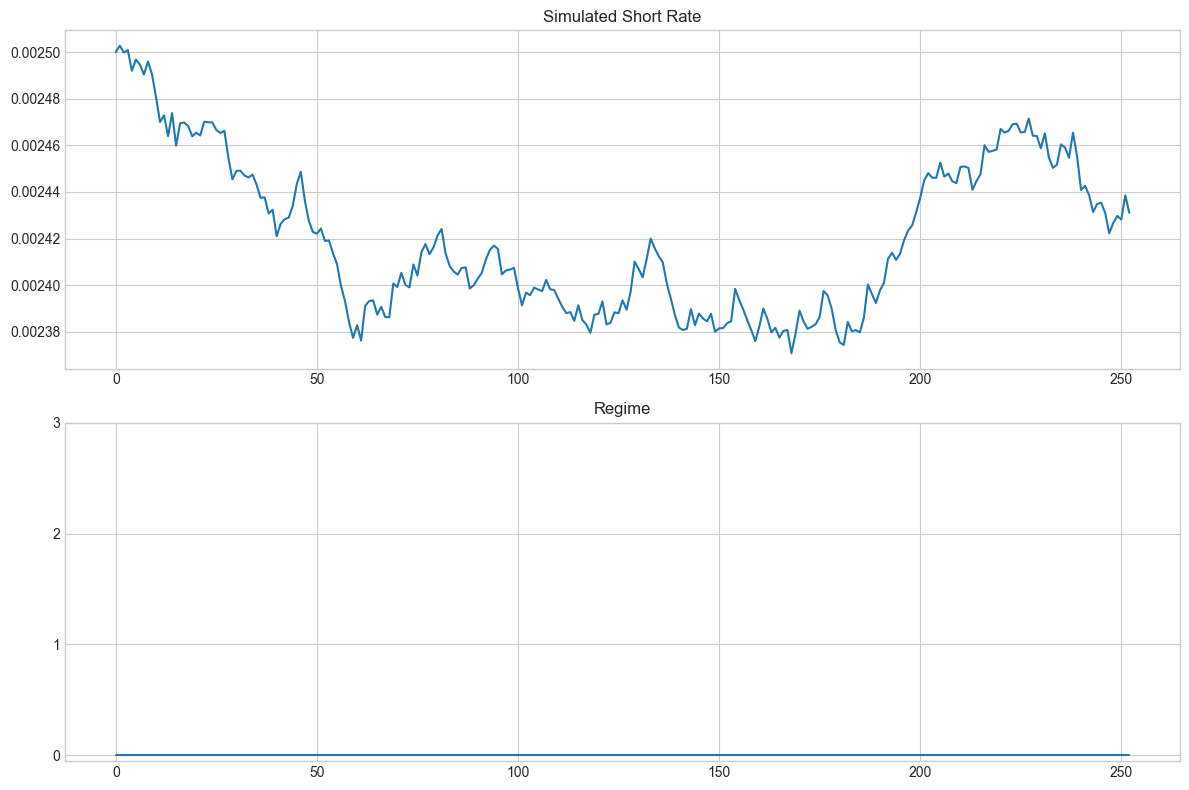

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [19]:
# Explore simulated data
rates_df = simulation_data['rates']
bond_prices_df = simulation_data['bond_prices']

# Plot short rate and regime
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(rates_df['spread_AA'])
plt.title('Simulated Short Rate')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rates_df['regime'])
plt.title('Regime')
plt.grid(True)
plt.yticks(range(n_regimes))

plt.tight_layout()
plt.show()

# Plot simulated bond prices and durations
plt.figure(figsize=(12, 8))


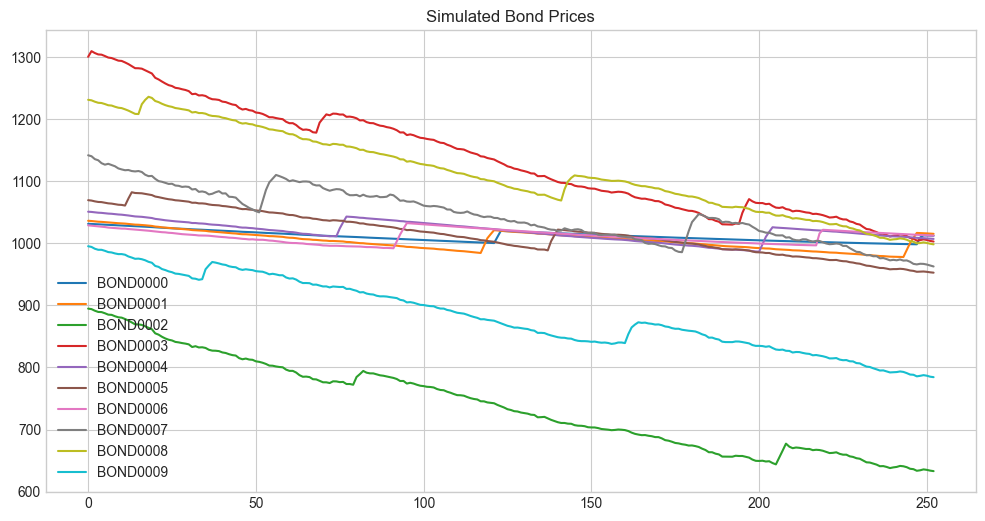

In [20]:
# Plot simulated bond prices
price_cols = [col for col in bond_prices_df.columns if 'price_' in col][:10]  # Plot first 5 bonds

plt.figure(figsize=(12, 6))
for col in price_cols:
    plt.plot(bond_prices_df[col], label=col.replace('price_', '')) # Normalize prices to initial value
plt.title('Simulated Bond Prices')
plt.legend()
plt.grid(True)
plt.show()

## 4. GNN for Credit Risk

Now, we'll implement a Graph Neural Network to model credit risk propagation through issuer relationships.

In [21]:
%pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [22]:
from src.models.gnn import CreditRiskGNN

# Create issuer nodes and edges
print("Creating issuer relationship data...")

# Check if we already have issuer data
if 'issuer_nodes' in raw_data and 'issuer_edges' in raw_data:
    nodes_df = raw_data['issuer_nodes']
    edges_df = raw_data['issuer_edges']
else:
    # Create synthetic data
    print("Generating synthetic issuer relationship data...")
    nodes_df, edges_df = data_loader.get_bond_issue_relationships()

print(f"Created {len(nodes_df)} nodes and {len(edges_df)} edges.")

# Display sample nodes and edges
print("\nSample issuer nodes:")
print(nodes_df.head())

print("\nSample issuer edges:")
print(edges_df.head())

Creating issuer relationship data...
Created 503 nodes and 2678 edges.

Sample issuer nodes:
                       name                  sector  \
ticker                                                
MMM                      3M             Industrials   
AOS             A. O. Smith             Industrials   
ABT     Abbott Laboratories             Health Care   
ABBV                 AbbVie             Health Care   
ACN               Accenture  Information Technology   

                              industry rating  
ticker                                         
MMM           Industrial Conglomerates      A  
AOS                  Building Products      B  
ABT              Health Care Equipment    BBB  
ABBV                     Biotechnology    BBB  
ACN     IT Consulting & Other Services     AA  

Sample issuer edges:
  source target relationship  weight
0    MMM    HON     industry     0.7
1    AOS   ALLE     industry     0.7
2    AOS   BLDR     industry     0.7
3    AOS   CARR

In [23]:
# Create GNN model
gnn = CreditRiskGNN(
    model_type='gcn',
    hidden_dim=64,
    device='cpu'  # Use CPU for demonstration
)

# Add credit spread as target
if 'credit_spread' not in nodes_df.columns:
    # Use existing credit_spread if available, otherwise generate synthetic
    nodes_df['credit_spread'] = nodes_df['rating'].map({
        'AAA': 0.003,
        'AA': 0.008,
        'A': 0.015,
        'BBB': 0.025,
        'BB': 0.045,
        'B': 0.08
    }).fillna(0.03) * (1 + np.random.normal(0, 0.2, size=len(nodes_df)))

# Prepare graph data
graph_data = gnn.prepare_graph_data(nodes_df, edges_df, target_col='credit_spread')
print(f"Prepared graph data with {graph_data.num_nodes} nodes and {graph_data.num_edges} edges.")

2025-03-21 22:04:01,177 - src.models.gnn - INFO - Using device: cpu
2025-03-21 22:04:01,178 - src.models.gnn - INFO - Preparing graph data with 503 nodes and 2678 edges
2025-03-21 22:04:01,178 - src.models.gnn - INFO - Nodes DataFrame index type: <class 'str'>
2025-03-21 22:04:01,179 - src.models.gnn - INFO - First 5 node indices: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']
2025-03-21 22:04:01,179 - src.models.gnn - INFO - Edges DataFrame source column type: <class 'str'>
2025-03-21 22:04:01,179 - src.models.gnn - INFO - First 5 source values: ['MMM', 'AOS', 'AOS', 'AOS', 'AOS']
2025-03-21 22:04:01,179 - src.models.gnn - INFO - Created node mapping with 503 entries
2025-03-21 22:04:01,179 - src.models.gnn - INFO - Sample node map entries: [('MMM', 0), ('AOS', 1), ('ABT', 2), ('ABBV', 3), ('ACN', 4)]
2025-03-21 22:04:01,233 - src.models.gnn - INFO - Successfully mapped source nodes: 2678/2678 (100.0%)
2025-03-21 22:04:01,233 - src.models.gnn - INFO - Successfully mapped target nodes: 2678/2678

Prepared graph data with 503 nodes and 5356 edges.


In [24]:
# Build and train model
gnn.build_model()
print("Training GNN model...")
losses = gnn.train(graph_data, epochs=100, verbose=True)

# Generate embeddings
embeddings = gnn.generate_node_embeddings(graph_data)
print(f"Generated embeddings with shape {embeddings.shape}.")

2025-03-21 22:04:01,241 - src.models.gnn - INFO - Building gcn model
2025-03-21 22:04:01,263 - src.models.gnn - INFO - Built gcn model with 64 hidden dimensions and 2 layers
2025-03-21 22:04:01,327 - src.models.gnn - INFO - Epoch 10/100, Loss: 0.0051
2025-03-21 22:04:01,348 - src.models.gnn - INFO - Epoch 20/100, Loss: 0.0013
2025-03-21 22:04:01,369 - src.models.gnn - INFO - Epoch 30/100, Loss: 0.0009


Training GNN model...


2025-03-21 22:04:01,392 - src.models.gnn - INFO - Epoch 40/100, Loss: 0.0006
2025-03-21 22:04:01,414 - src.models.gnn - INFO - Epoch 50/100, Loss: 0.0005
2025-03-21 22:04:01,435 - src.models.gnn - INFO - Epoch 60/100, Loss: 0.0004
2025-03-21 22:04:01,461 - src.models.gnn - INFO - Epoch 70/100, Loss: 0.0004
2025-03-21 22:04:01,485 - src.models.gnn - INFO - Epoch 80/100, Loss: 0.0004
2025-03-21 22:04:01,516 - src.models.gnn - INFO - Epoch 90/100, Loss: 0.0004
2025-03-21 22:04:01,550 - src.models.gnn - INFO - Epoch 100/100, Loss: 0.0004
2025-03-21 22:04:01,550 - src.models.gnn - INFO - Training completed with final loss: 0.0004


Generated embeddings with shape (503, 64).


2025-03-21 22:04:01,558 - src.models.gnn - INFO - Plotting graph with 503 nodes and 5356 edges
2025-03-21 22:04:01,559 - src.models.gnn - INFO - Converting 5356 edges from PyG to NetworkX
2025-03-21 22:04:01,575 - src.models.gnn - INFO - NetworkX graph has 503 nodes and 2678 edges


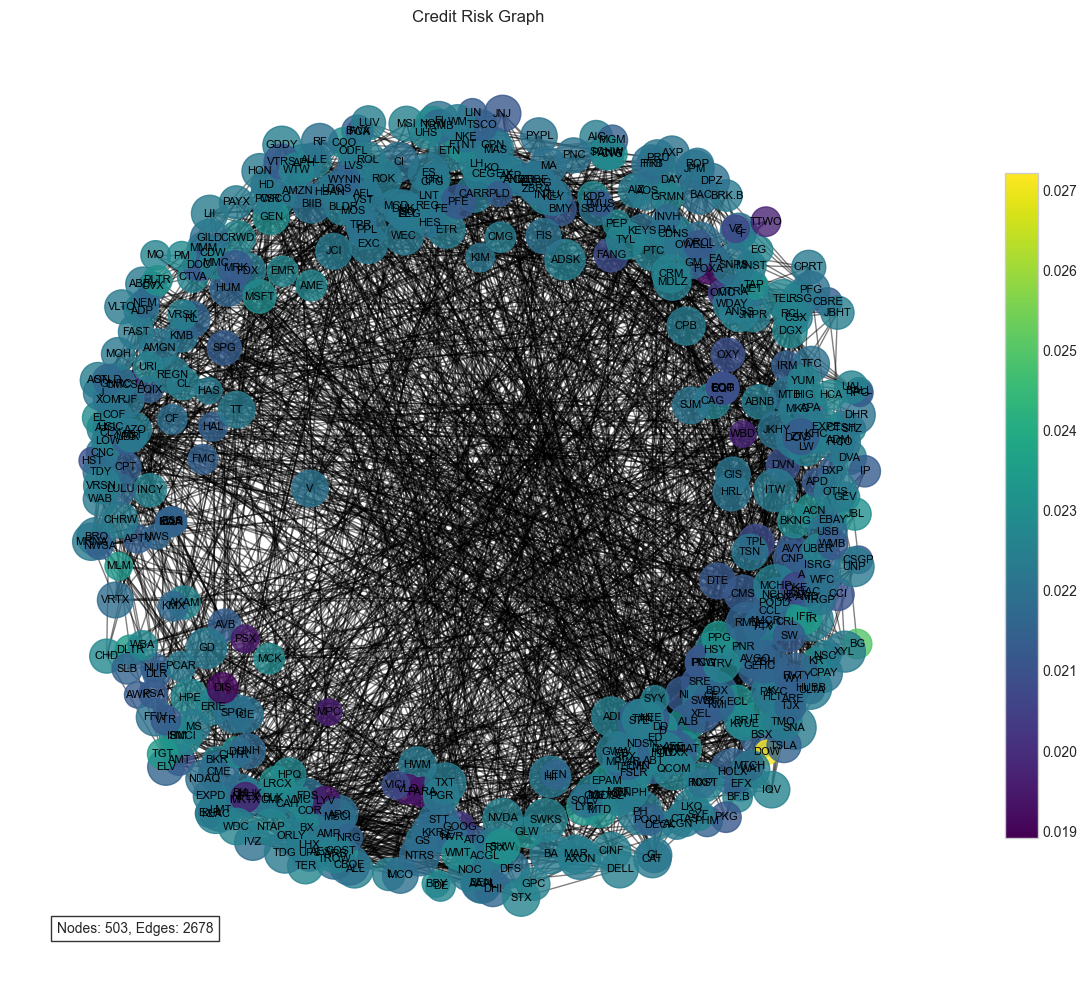

In [25]:
# Plot graph
fig = gnn.plot_graph(
    graph_data,
    node_labels=nodes_df.index.tolist(),
    predictions=gnn.predict(graph_data)
)
plt.show()

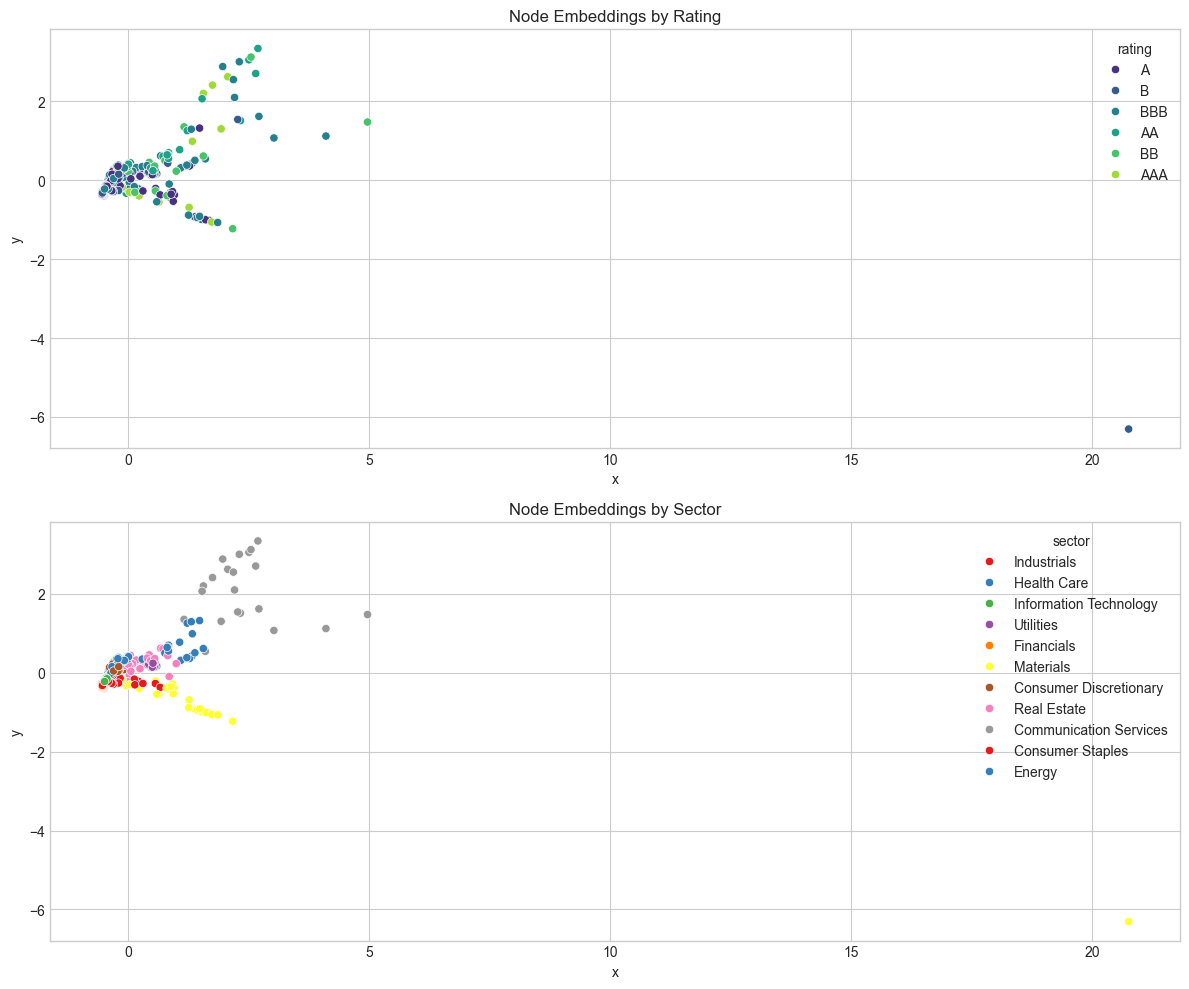

In [26]:
# Analyze embeddings with PCA
from sklearn.decomposition import PCA

# Apply PCA to embeddings
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create DataFrame for plotting
embeddings_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'rating': nodes_df['rating'],
    'sector': nodes_df['sector'],
    'credit_spread': nodes_df['credit_spread']
})

# Plot embeddings by rating
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(data=embeddings_df, x='x', y='y', hue='rating', palette='viridis')
plt.title('Node Embeddings by Rating')

plt.subplot(2, 1, 2)
sns.scatterplot(data=embeddings_df, x='x', y='y', hue='sector', palette='Set1')
plt.title('Node Embeddings by Sector')

plt.tight_layout()
plt.show()

## 5. RL Environment Setup

Now, we'll set up the reinforcement learning environment for fixed income portfolio management.

In [27]:
simulation_data['bond_prices']

,price_BOND0000,duration_BOND0000,convexity_BOND0000,price_BOND0001,duration_BOND0001,convexity_BOND0001,price_BOND0002,duration_BOND0002,convexity_BOND0002,price_BOND0003,...,convexity_BOND0006,price_BOND0007,duration_BOND0007,convexity_BOND0007,price_BOND0008,duration_BOND0008,convexity_BOND0008,price_BOND0009,duration_BOND0009,convexity_BOND0009
0,1031.211391,1.473695,2.193039,1036.075029,2.418372,5.964910,894.719450,15.739813,274.939926,1300.000000,...,2.154530,1141.501890,7.329092,62.886232,1230.795477,8.881467,89.907277,995.100736,10.907054,132.923718
1,1030.948169,1.473694,2.193036,1035.682107,2.418362,5.964877,893.888738,15.738442,274.908912,1309.128037,...,2.154507,1139.990544,7.327874,62.872159,1229.950898,8.880911,89.899781,993.973630,10.905845,132.904423
2,1030.641687,1.473689,2.193027,1035.033193,2.418331,5.964776,891.308559,15.733506,274.797221,1306.048292,...,2.154460,1135.319027,7.322876,62.814394,1227.743036,8.878912,89.872796,991.058556,10.902209,132.846395
3,1030.356035,1.473687,2.193021,1034.560196,2.418315,5.964722,889.351519,15.729826,274.713940,1303.833251,...,2.154439,1133.471121,7.321249,62.795587,1226.018290,8.877421,89.852690,989.384215,10.900250,132.815128
4,1030.126524,1.473687,2.193021,1034.322657,2.418317,5.964730,889.082778,15.729596,274.708738,1303.445773,...,2.154447,1128.755671,7.316164,62.736832,1225.609946,8.877328,89.851434,989.352894,10.900526,132.819535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1009.154716,0.500000,0.250000,1016.294527,1.474676,2.195208,634.463927,14.378692,235.323394,1004.941984,...,0.250000,966.891537,6.541285,50.260356,1000.266769,7.987925,73.348602,786.509175,9.907671,111.012113
249,1012.548145,0.500000,0.250000,1016.074522,1.474680,2.195216,635.903900,14.384080,235.437325,1006.167292,...,0.250000,966.679757,6.541729,50.264942,1001.301389,7.989725,73.370584,787.616487,9.910094,111.047572
250,1012.364276,0.500000,0.250000,1015.750238,1.474678,2.195213,635.125502,14.382148,235.396482,1005.178547,...,0.250000,965.618137,6.541069,50.258122,1000.392775,7.989079,73.362702,786.689452,9.908978,111.031242
251,1012.191902,0.500000,0.250000,1015.391428,1.474674,2.195205,633.909067,14.378766,235.324971,1003.649088,...,0.250000,964.002952,6.539689,50.243860,999.099543,7.987950,73.348906,785.094388,9.906698,110.997861


In [28]:
from src.environment.fixed_income_env import FixedIncomeEnv
from src.environment.reward_function import create_reward_function

# Prepare market data for the environment
market_data = {
    'rates': simulation_data['rates'],
    'bond_prices': simulation_data['bond_prices']
}

# Create environment
env = FixedIncomeEnv(
    market_data=market_data,
    bond_universe=bond_universe,
    num_assets=10,  # Use a subset of assets for simplicity
    rebalance_freq=5,  # Monthly rebalancing
    transaction_cost=0.0005,
    reward_type='cumulative_return',
    regime_aware=True,
    duration_constraint=(1.0, 10.0),  # Set duration constraints
    random_start=True,
    window_size=63,  # ~3 months lookback
    risk_free_rate=0.02 / 252  # Daily risk-free rate
)

# Test the environment
print("Testing environment...")
observation, info = env.reset()
print(f"Observation shape: {observation.shape}")
print(f"Action space: {env.action_space}")

# Take a random action
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)
print(f"Reward: {reward:.4f}")
print(f"Info: {info}")

2025-03-21 22:04:02,741 - src.environment.reward_function - WARNING - Unknown reward type 'cumulative_return'. Using default ReturnReward.
2025-03-21 22:04:02,741 - src.environment.fixed_income_env - INFO - Creating asset features
2025-03-21 22:04:02,742 - src.environment.fixed_income_env - INFO - Selected assets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2025-03-21 22:04:02,742 - src.environment.fixed_income_env - INFO - Available bond price columns: ['price_BOND0000', 'duration_BOND0000', 'convexity_BOND0000', 'price_BOND0001', 'duration_BOND0001', 'convexity_BOND0001', 'price_BOND0002', 'duration_BOND0002', 'convexity_BOND0002', 'price_BOND0003']...
2025-03-21 22:04:02,742 - src.environment.fixed_income_env - INFO - Found 10 price columns, 10 duration columns, and 10 convexity columns
2025-03-21 22:04:02,744 - src.environment.fixed_income_env - INFO - Created asset features with shapes: prices (253, 10), durations (253, 10), convexities (253, 10)
2025-03-21 22:04:02,744 - src.environment.fixed

Testing environment...
Observation shape: (670,)
Action space: Box(0.0, 1.0, (10,), float32)
Reward: -0.0207
Info: {'portfolio_value': np.float64(999793.0315761941), 'portfolio_weights': array([0.10000137, 0.09998461, 0.09985578, 0.09991738, 0.09997527,
       0.09996667, 0.10000049, 0.09994282, 0.09991685, 0.10043876]), 'portfolio_return': np.float64(-0.00020696842380585334), 'portfolio_duration': np.float64(6.18243243950093), 'portfolio_convexity': np.float64(67.14154784505057), 'cumulative_return': np.float64(-0.00020696842380585334), 'max_drawdown': np.float64(0.00020696842380589806), 'regime': np.int64(0), 'duration_violation': 0.0}


In [29]:
# Test the environment with a random strategy
print("Testing environment with random strategy...")
observation, info = env.reset()
done = False
total_reward = 0
steps = 0

while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    steps += 1
    done = terminated or truncated

print(f"Episode finished after {steps} steps with total reward {total_reward:.4f}")
print(f"Portfolio value: {info['portfolio_value']:.2f}")
print(f"Cumulative return: {info['cumulative_return']:.4%}")

Testing environment with random strategy...
Episode finished after 100 steps with total reward -5.9014
Portfolio value: 935784.98
Cumulative return: -6.4215%


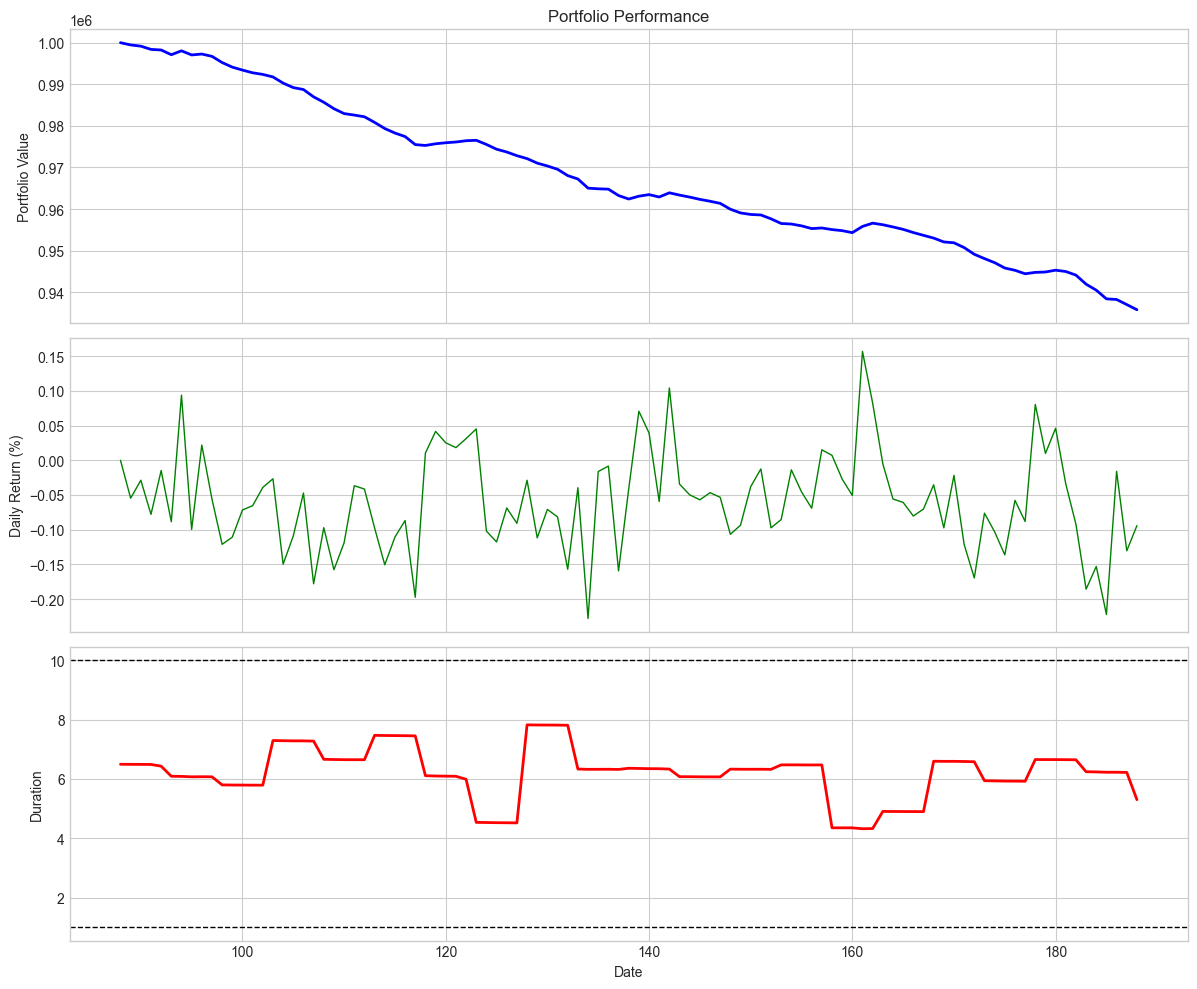

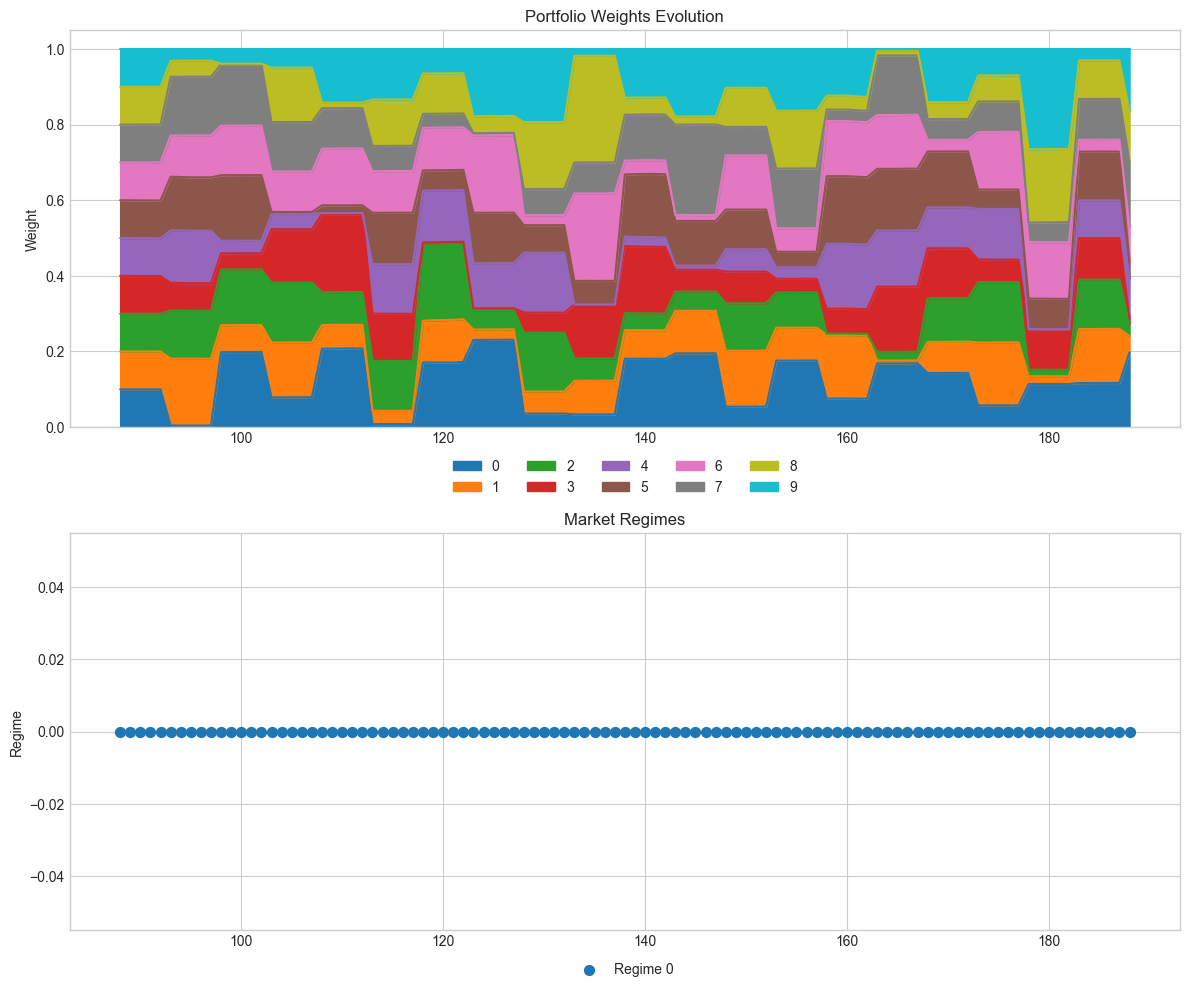

In [30]:
# Plot portfolio performance
fig = env.plot_portfolio_performance()
plt.show()

# Plot weights evolution
fig = env.plot_weights_evolution()
plt.show()

## 6. RL Agent Training

Next, we'll train a reinforcement learning agent to optimize portfolio allocation.

In [31]:
from src.models.rl_agent import TD3Agent, train_agent, evaluate_agent

# Create TD3 agent
agent = TD3Agent(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dim=256, 
    actor_lr=1e-5,
    critic_lr=1e-4,
    gamma=0.99,
    tau=0.005,
    batch_size=128,
    buffer_size=10000,  
    policy_update_freq=2,
    policy_noise=0.2,
    noise_clip=0.5,
    device='cpu'
)

2025-03-21 22:04:03,024 - src.models.rl_agent - INFO - Initializing TD3Agent with state_dim=670
2025-03-21 22:04:03,024 - src.models.rl_agent - INFO - Using device: cpu
2025-03-21 22:04:03,024 - src.models.rl_agent - INFO - Initializing ActorNetwork with state_dim=670, action_dim=10, hidden_dim=256
2025-03-21 22:04:03,025 - src.models.rl_agent - INFO - Initializing ActorNetwork with state_dim=670, action_dim=10, hidden_dim=256


In [32]:
# Train agent 
print("Training TD3 agent...")
metrics = train_agent(
    agent=agent,
    env=env,
    episodes=40,  
    max_steps=500,
    eval_freq=5,
    save_path=None, 
)

2025-03-21 22:04:03,046 - src.models.rl_agent - INFO - Episode 1/40, Reward: -1.38, Steps: 22
2025-03-21 22:04:03,099 - src.models.rl_agent - INFO - Episode 2/40, Reward: -5.79, Steps: 100
/Users/ranystephan/Desktop/RIFLE/src/models/rl_agent.py:631: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states = torch.FloatTensor([e.state for e in experiences]).to(self.device)


Training TD3 agent...


2025-03-21 22:04:03,325 - src.models.rl_agent - INFO - Episode 3/40, Reward: -0.55, Steps: 13
2025-03-21 22:04:04,854 - src.models.rl_agent - INFO - Episode 4/40, Reward: -4.93, Steps: 90
2025-03-21 22:04:05,804 - src.models.rl_agent - INFO - Episode 5/40, Reward: -2.50, Steps: 57
2025-03-21 22:04:06,011 - src.models.rl_agent - INFO - Evaluation - Average Reward: -4.02, Average Steps: 79.80
2025-03-21 22:04:07,019 - src.models.rl_agent - INFO - Episode 6/40, Reward: -3.42, Steps: 62
2025-03-21 22:04:08,928 - src.models.rl_agent - INFO - Episode 7/40, Reward: -5.95, Steps: 107
2025-03-21 22:04:10,406 - src.models.rl_agent - INFO - Episode 8/40, Reward: -4.09, Steps: 88
2025-03-21 22:04:12,081 - src.models.rl_agent - INFO - Episode 9/40, Reward: -5.00, Steps: 101
2025-03-21 22:04:13,127 - src.models.rl_agent - INFO - Episode 10/40, Reward: -3.57, Steps: 65
2025-03-21 22:04:13,388 - src.models.rl_agent - INFO - Evaluation - Average Reward: -4.06, Average Steps: 83.20
2025-03-21 22:04:14,2

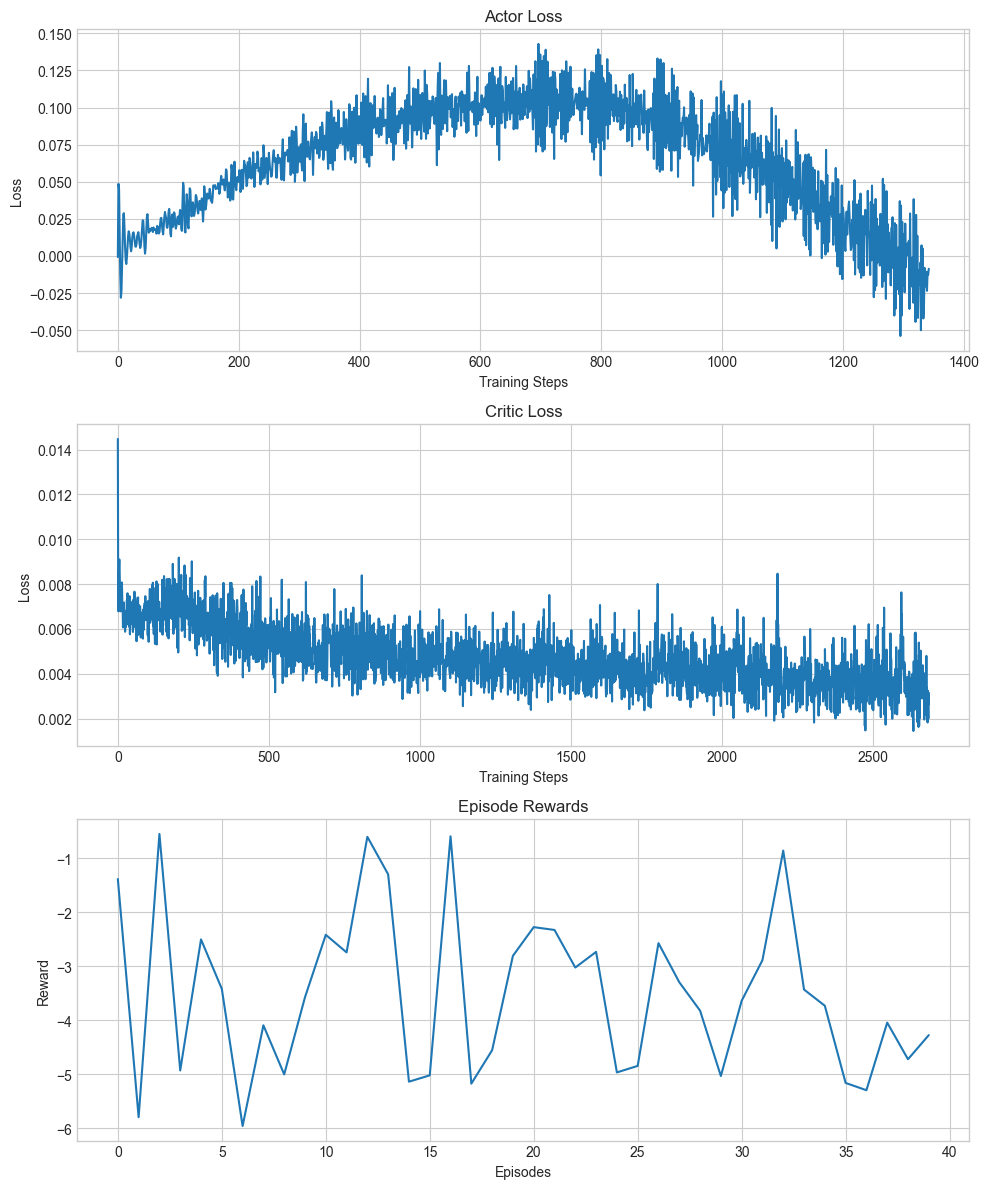

In [39]:

# Plot learning curves
fig = agent.plot_learning_curves()
plt.show()


In [40]:
# Evaluate agent
print("Evaluating agent...")
avg_reward, avg_steps = evaluate_agent(
    agent=agent,
    env=env,
    episodes=5,
    max_steps=500
)
print(f"Evaluation - Average reward: {avg_reward:.2f}, Average steps: {avg_steps:.2f}")

# Run an episode for visualization
observation, info = env.reset()
done = False
total_reward = 0
steps = 0

while not done:
    action = agent.select_action(observation, eval_mode=True)
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    steps += 1
    done = terminated or truncated

print(f"Evaluation episode finished after {steps} steps with total reward {total_reward:.4f}")
print(f"Portfolio value: {info['portfolio_value']:.2f}")
print(f"Cumulative return: {info['cumulative_return']:.4%}")
print(f"Sharpe ratio: {info.get('sharpe_ratio', 'N/A')}")

Evaluating agent...
Evaluation - Average reward: -3.07, Average steps: 63.20
Evaluation episode finished after 63 steps with total reward -3.1564
Portfolio value: 968600.23
Cumulative return: -3.1400%
Sharpe ratio: -14.230045349994299


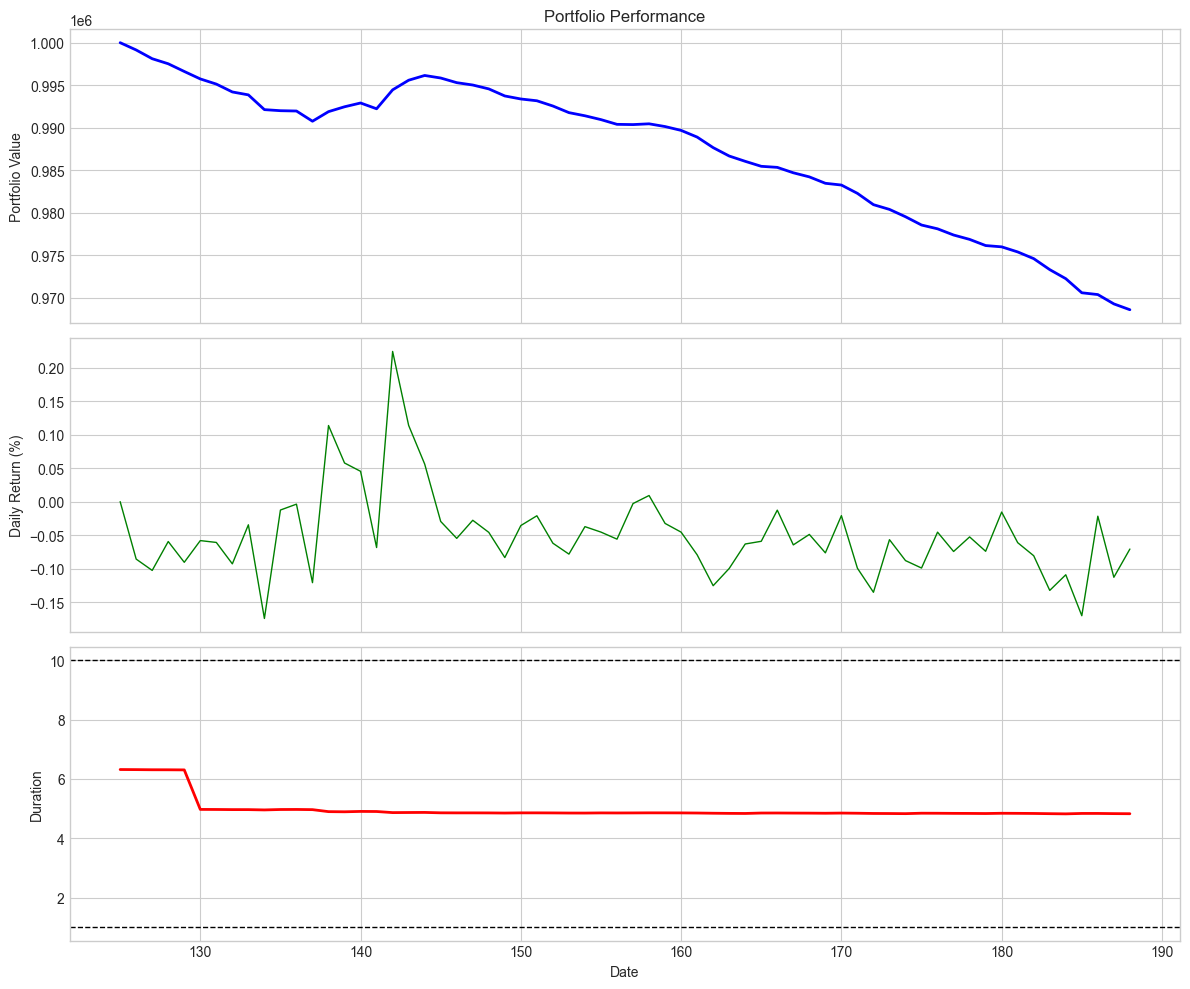

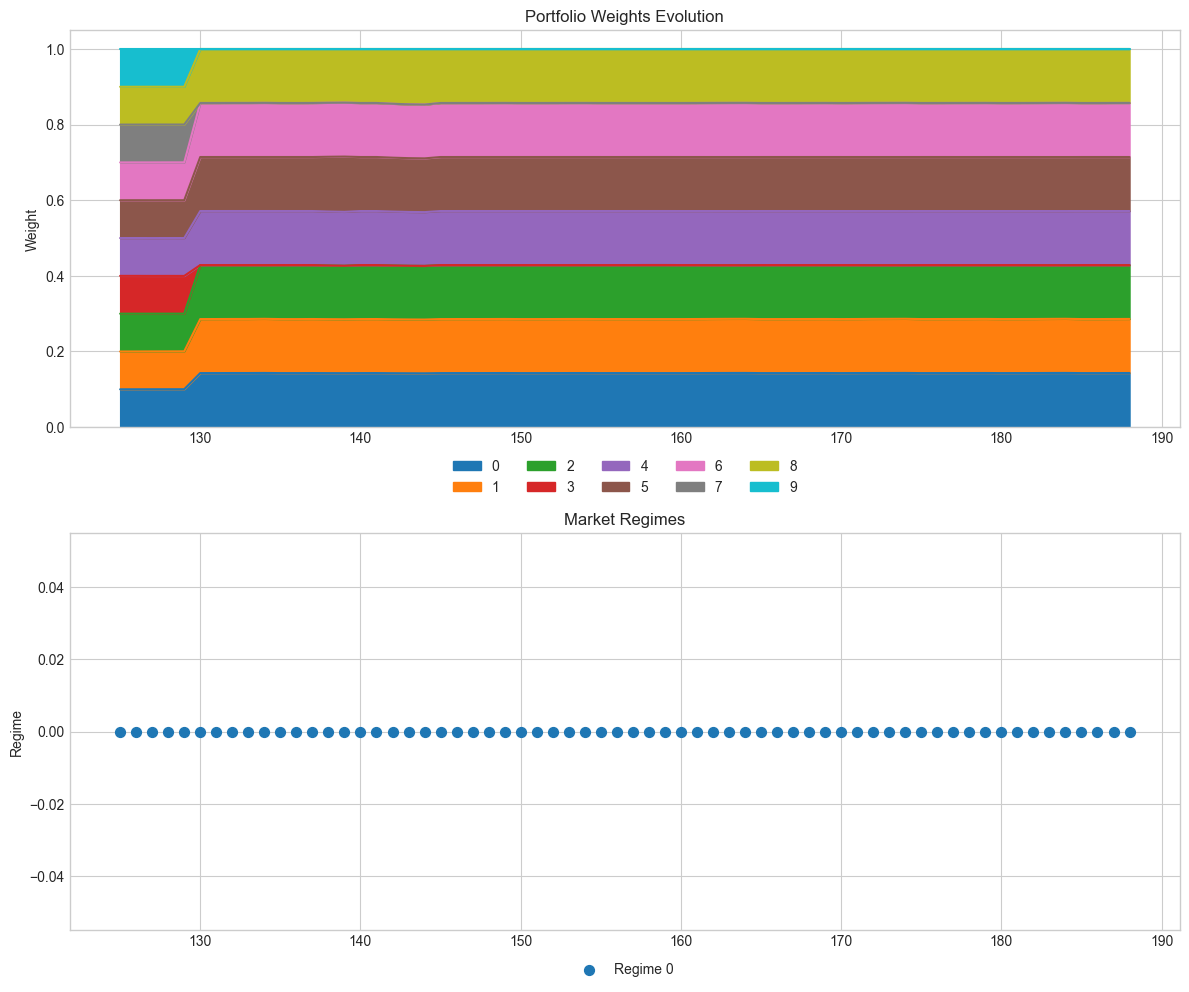

In [41]:
# Plot portfolio performance
fig = env.plot_portfolio_performance()
plt.show()

# Plot weights evolution
fig = env.plot_weights_evolution()
plt.show()

## 7. Backtesting and Evaluation

Finally, we'll backtest and evaluate our RL strategy against benchmarks.

In [42]:
from src.backtesting.backtest_engine import BacktestEngine, RegimeClassifierStrategy, DurationTargetingStrategy, RLAgentStrategy
from src.models.portfolio_optimizer import FixedIncomePortfolioOptimizer

# Create backtest engine
engine = BacktestEngine(
    market_data=market_data,
    bond_universe=bond_universe,
    initial_capital=1000000.0,
    rebalance_freq=21,  # Monthly rebalancing
    transaction_cost=0.0005,
    risk_free_rate=0.02,  # Annual risk-free rate
    use_regimes=True,
    start_date=None,  # Use first date in data
    end_date=None  # Use last date in data
)

2025-03-21 22:07:01,115 - src.backtesting.backtest_engine - INFO - Running backtest from 0 to 252
2025-03-21 22:07:01,116 - src.backtesting.backtest_engine - INFO - Initial portfolio value: 1000000.0
2025-03-21 22:07:01,116 - src.backtesting.backtest_engine - INFO - Number of assets: 10
2025-03-21 22:07:01,118 - src.backtesting.backtest_engine - INFO - First few prices: [1031.21139073 1036.07502932  894.71944972 1300.         1050.67900633]
2025-03-21 22:07:01,192 - src.backtesting.backtest_engine - INFO - Backtest diagnostics:
2025-03-21 22:07:01,193 - src.backtesting.backtest_engine - INFO -   Total rebalances: 12
2025-03-21 22:07:01,193 - src.backtesting.backtest_engine - INFO -   Extreme movements: 0
2025-03-21 22:07:01,193 - src.backtesting.backtest_engine - INFO -   Final portfolio value: 868226.19
2025-03-21 22:07:01,193 - src.backtesting.backtest_engine - INFO -   Total return: -0.1317
2025-03-21 22:07:01,194 - src.backtesting.backtest_engine - INFO -   Average return: -0.00056

Running backtest for equal weight strategy...


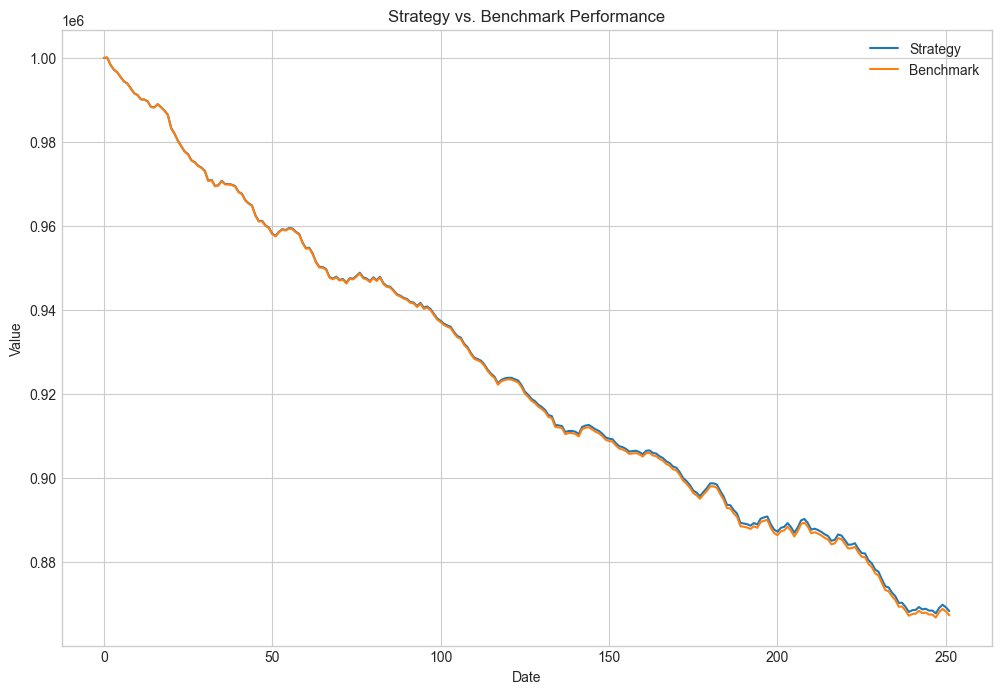


Equal weight strategy performance:
Total return: -13.1705%
Annualized return: -13.1705%
Volatility: 1.3476%
Sharpe ratio: -11.9542
Max drawdown: 13.2327%


In [43]:
# 1. Equal weight strategy (benchmark)
def equal_weight_strategy(market_snapshot, args):
    num_assets = len(market_snapshot['bond_universe'])
    return np.ones(num_assets) / num_assets

print("Running backtest for equal weight strategy...")
eq_results = engine.run_backtest(equal_weight_strategy)

# Plot results
fig = engine.plot_performance()
plt.show()

# Print metrics
print("\nEqual weight strategy performance:")
print(f"Total return: {eq_results['metrics']['total_return']:.4%}")
print(f"Annualized return: {eq_results['metrics']['annualized_return']:.4%}")
print(f"Volatility: {eq_results['metrics']['volatility']:.4%}")
print(f"Sharpe ratio: {eq_results['metrics']['sharpe_ratio']:.4f}")
print(f"Max drawdown: {eq_results['metrics']['max_drawdown']:.4%}")

2025-03-21 22:07:01,358 - src.backtesting.backtest_engine - INFO - Running backtest from 0 to 252
2025-03-21 22:07:01,359 - src.backtesting.backtest_engine - INFO - Initial portfolio value: 1000000.0
2025-03-21 22:07:01,359 - src.backtesting.backtest_engine - INFO - Number of assets: 10
2025-03-21 22:07:01,360 - src.backtesting.backtest_engine - INFO - First few prices: [1031.21139073 1036.07502932  894.71944972 1300.         1050.67900633]
2025-03-21 22:07:01,429 - src.backtesting.backtest_engine - INFO - Backtest diagnostics:
2025-03-21 22:07:01,429 - src.backtesting.backtest_engine - INFO -   Total rebalances: 12
2025-03-21 22:07:01,429 - src.backtesting.backtest_engine - INFO -   Extreme movements: 0
2025-03-21 22:07:01,429 - src.backtesting.backtest_engine - INFO -   Final portfolio value: 847015.68
2025-03-21 22:07:01,430 - src.backtesting.backtest_engine - INFO -   Total return: -0.1527
2025-03-21 22:07:01,430 - src.backtesting.backtest_engine - INFO -   Average return: -0.00065

Running backtest for regime-based strategy...


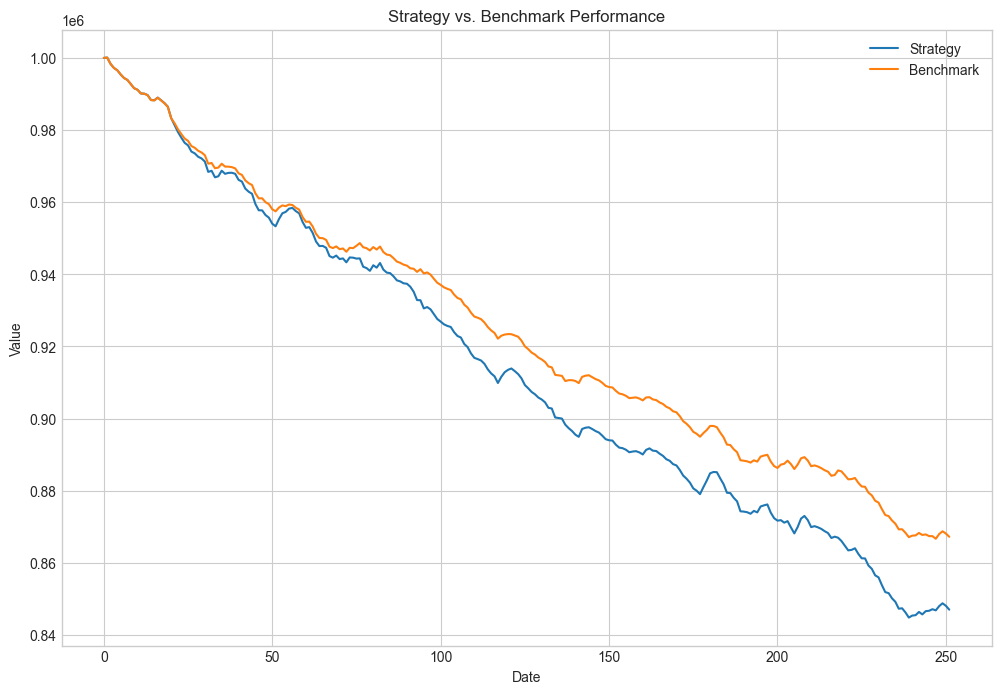

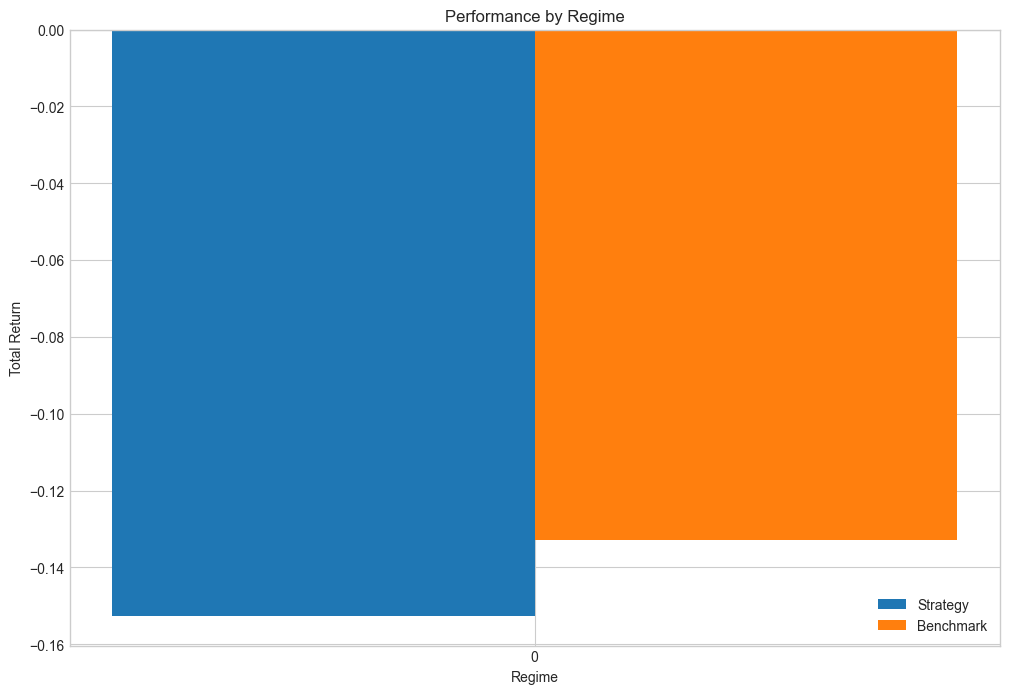


Regime-based strategy performance:
Total return: -15.2696%
Annualized return: -15.2696%
Volatility: 1.7269%
Sharpe ratio: -10.7414
Max drawdown: 15.4964%


In [44]:
# 2. Regime-based strategy
# Define weights for each regime
num_assets = len(bond_universe)
regime_weights = {}

# Sample regime-specific weights
np.random.seed(42)
for regime in range(n_regimes):
    # Generate random weights
    weights = np.random.rand(num_assets)
    # Normalize to sum to 1
    weights = weights / np.sum(weights)
    regime_weights[regime] = weights

# Create regime strategy
regime_strategy = RegimeClassifierStrategy(
    regime_detector=None,  # Use pre-computed regimes
    regime_weights=regime_weights
)

print("Running backtest for regime-based strategy...")
regime_results = engine.run_backtest(regime_strategy)

# Plot results
fig = engine.plot_performance()
plt.show()

# Plot regime performance
fig = engine.plot_regime_performance()
plt.show()

# Print metrics
print("\nRegime-based strategy performance:")
print(f"Total return: {regime_results['metrics']['total_return']:.4%}")
print(f"Annualized return: {regime_results['metrics']['annualized_return']:.4%}")
print(f"Volatility: {regime_results['metrics']['volatility']:.4%}")
print(f"Sharpe ratio: {regime_results['metrics']['sharpe_ratio']:.4f}")
print(f"Max drawdown: {regime_results['metrics']['max_drawdown']:.4%}")

2025-03-21 22:07:01,577 - src.backtesting.backtest_engine - INFO - Running backtest from 0 to 252
2025-03-21 22:07:01,577 - src.backtesting.backtest_engine - INFO - Initial portfolio value: 1000000.0
2025-03-21 22:07:01,577 - src.backtesting.backtest_engine - INFO - Number of assets: 10
2025-03-21 22:07:01,578 - src.backtesting.backtest_engine - INFO - First few prices: [1031.21139073 1036.07502932  894.71944972 1300.         1050.67900633]
2025-03-21 22:07:01,586 - src.models.portfolio_optimizer - INFO - Performing duration-matching optimization with target duration 2.0
2025-03-21 22:07:01,593 - src.models.portfolio_optimizer - INFO - Duration-matching optimization succeeded with optimal value: -0.000196
2025-03-21 22:07:01,602 - src.models.portfolio_optimizer - INFO - Performing duration-matching optimization with target duration 2.0
2025-03-21 22:07:01,606 - src.models.portfolio_optimizer - INFO - Duration-matching optimization succeeded with optimal value: -0.000264
2025-03-21 22:0

Running backtest for duration targeting strategy...


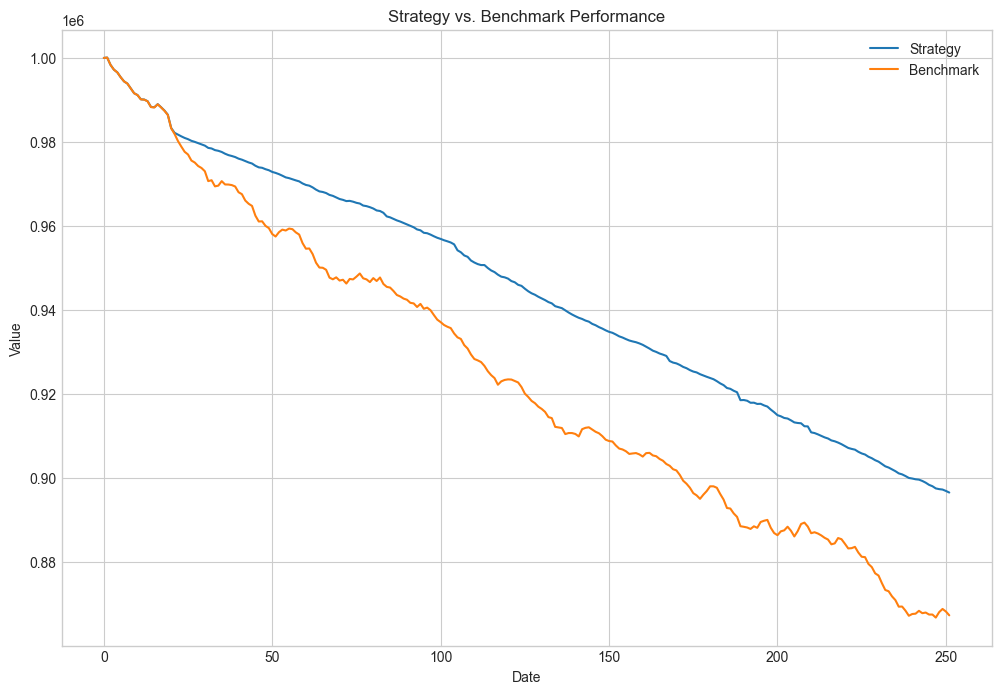


Duration targeting strategy performance:
Total return: -9.8416%
Annualized return: -9.8416%
Volatility: 0.4769%
Sharpe ratio: -25.9113
Max drawdown: 9.8491%


In [45]:
# 3. Duration targeting strategy
# Define target durations for each regime
regime_durations = {
    0: 2.0,  # Short duration in regime 0
    1: 5.0,  # Medium duration in regime 1
    2: 8.0,  # Long duration in regime 2
    3: 3.5   # Medium-short duration in regime 3
}

# Create portfolio optimizer
optimizer = FixedIncomePortfolioOptimizer()

# Create strategy
duration_strategy = DurationTargetingStrategy(
    regime_detector=None,  # Use pre-computed regimes
    regime_durations=regime_durations,
    portfolio_optimizer=optimizer
)

print("Running backtest for duration targeting strategy...")
duration_results = engine.run_backtest(duration_strategy)

# Plot results
fig = engine.plot_performance()
plt.show()

# Print metrics
print("\nDuration targeting strategy performance:")
print(f"Total return: {duration_results['metrics']['total_return']:.4%}")
print(f"Annualized return: {duration_results['metrics']['annualized_return']:.4%}")
print(f"Volatility: {duration_results['metrics']['volatility']:.4%}")
print(f"Sharpe ratio: {duration_results['metrics']['sharpe_ratio']:.4f}")
print(f"Max drawdown: {duration_results['metrics']['max_drawdown']:.4%}")

2025-03-21 22:07:01,938 - src.backtesting.backtest_engine - INFO - Running backtest from 0 to 252
2025-03-21 22:07:01,939 - src.backtesting.backtest_engine - INFO - Initial portfolio value: 1000000.0
2025-03-21 22:07:01,939 - src.backtesting.backtest_engine - INFO - Number of assets: 10
2025-03-21 22:07:01,940 - src.backtesting.backtest_engine - INFO - First few prices: [1031.21139073 1036.07502932  894.71944972 1300.         1050.67900633]
2025-03-21 22:07:01,949 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 236. Adapting...
2025-03-21 22:07:01,958 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 446. Adapting...
2025-03-21 22:07:01,968 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...


Running backtest for RL-based strategy...


2025-03-21 22:07:01,977 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:01,987 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:01,995 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:02,004 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:02,012 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:02,020 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:02,028 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:02,036 - src.models.rl_agent - WARNING - State dimension mismatch: expected 670, got 656. Adapting...
2025-03-21 22:07:02,042 - src.models.rl_agent - 

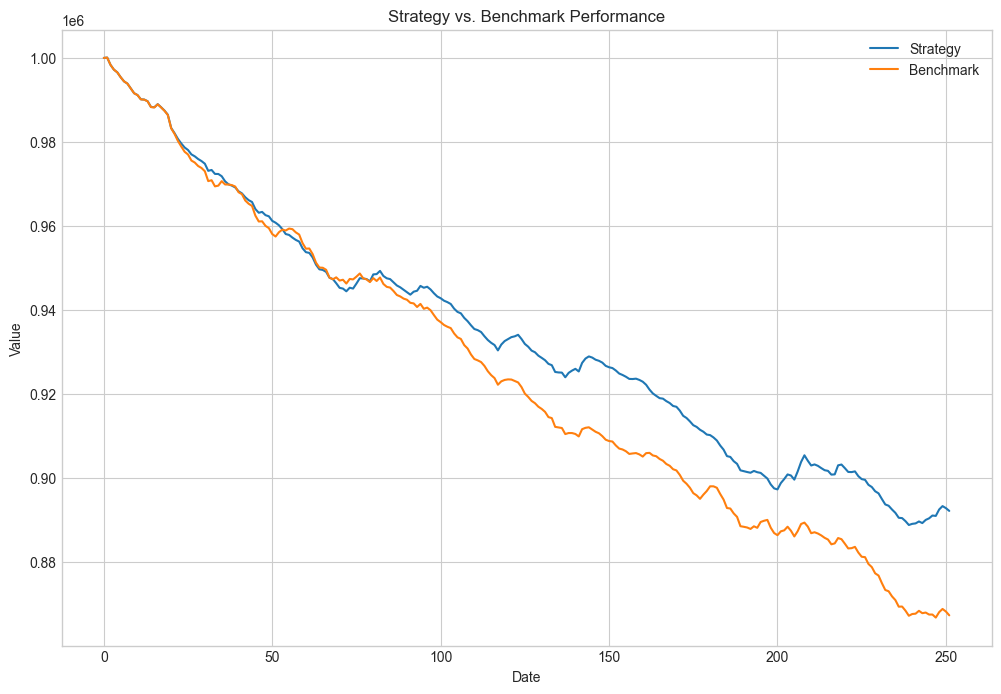


RL-based strategy performance:
Total return: -10.7588%
Annualized return: -10.7588%
Volatility: 1.2637%
Sharpe ratio: -10.5822
Max drawdown: 11.1018%


In [46]:
# 4. RL-based strategy
rl_strategy = RLAgentStrategy(
    agent=agent
)

print("Running backtest for RL-based strategy...")
rl_results = engine.run_backtest(rl_strategy)

# Plot results
fig = engine.plot_performance()
plt.show()

# Print metrics
print("\nRL-based strategy performance:")
print(f"Total return: {rl_results['metrics']['total_return']:.4%}")
print(f"Annualized return: {rl_results['metrics']['annualized_return']:.4%}")
print(f"Volatility: {rl_results['metrics']['volatility']:.4%}")
print(f"Sharpe ratio: {rl_results['metrics']['sharpe_ratio']:.4f}")
print(f"Max drawdown: {rl_results['metrics']['max_drawdown']:.4%}")

In [47]:
# Compare strategies
from src.backtesting.performance_metrics import PerformanceMetrics

# Collect all returns
all_returns = pd.DataFrame({
    'Equal Weight': eq_results['strategy_returns'],
    'Regime-Based': regime_results['strategy_returns'],
    'Duration Targeting': duration_results['strategy_returns'],
    'RL-Based': rl_results['strategy_returns']
})

# Calculate performance metrics
metrics = PerformanceMetrics()
all_metrics = {}

for strategy in all_returns.columns:
    all_metrics[strategy] = metrics.calculate_return_metrics(
        all_returns[strategy],
        risk_free_rate=0.02 / 252  # Daily risk-free rate
    )

# Create comparison DataFrame
metrics_df = pd.DataFrame({
    strategy: {
        'Annualized Return': metrics['annualized_return'],
        'Volatility': metrics['annualized_volatility'],
        'Sharpe Ratio': metrics['sharpe_ratio'],
        'Sortino Ratio': metrics['sortino_ratio'],
        'Max Drawdown': metrics.get('max_drawdown', np.nan),
        'Positive Returns %': metrics['positive_returns_pct']
    }
    for strategy, metrics in all_metrics.items()
})

# Display comparison
print("\nStrategy Comparison:")
print(metrics_df)


Strategy Comparison:
                    Equal Weight  Regime-Based  Duration Targeting   RL-Based
Annualized Return      -0.131705     -0.152696           -0.098416  -0.107588
Volatility              0.013476      0.017269            0.004769   0.012637
Sharpe Ratio          -11.954245    -10.741429          -25.911287 -10.582235
Sortino Ratio         -17.047386    -16.121275          -26.769259 -18.412297
Max Drawdown                 NaN           NaN                 NaN        NaN
Positive Returns %      0.230159      0.230159            0.027778   0.186508


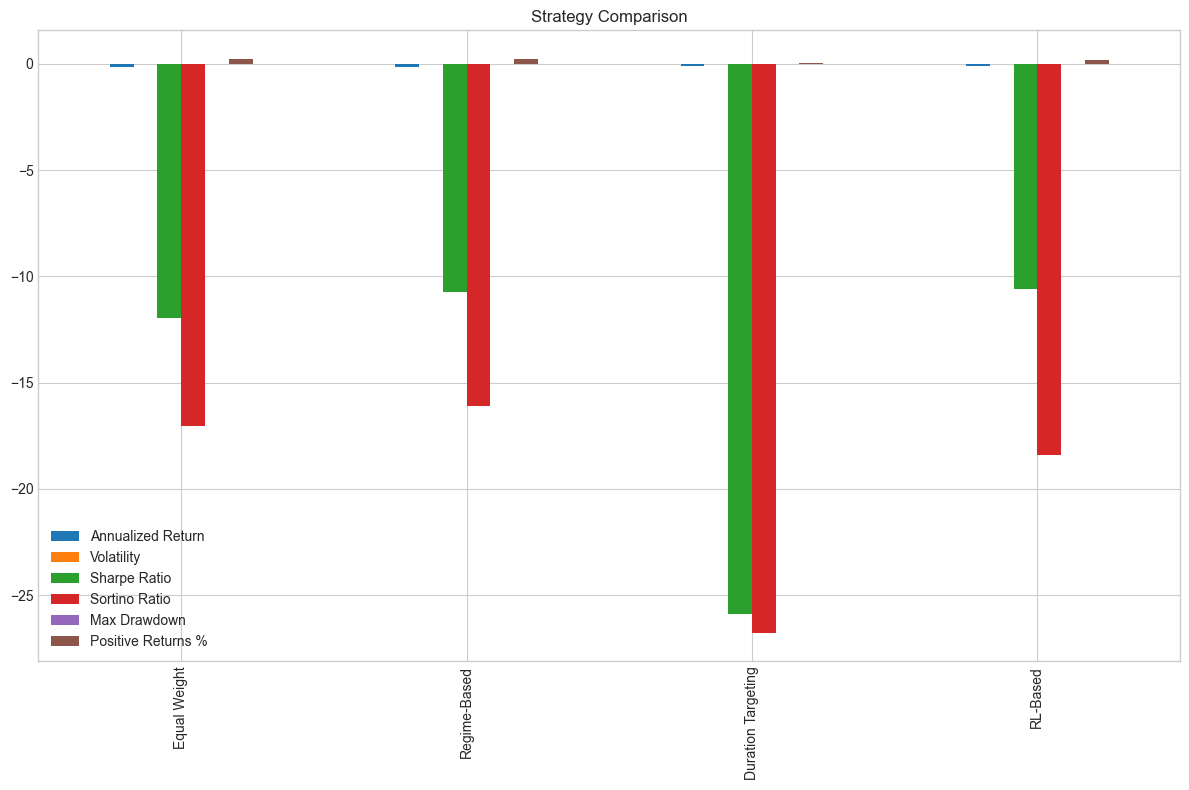

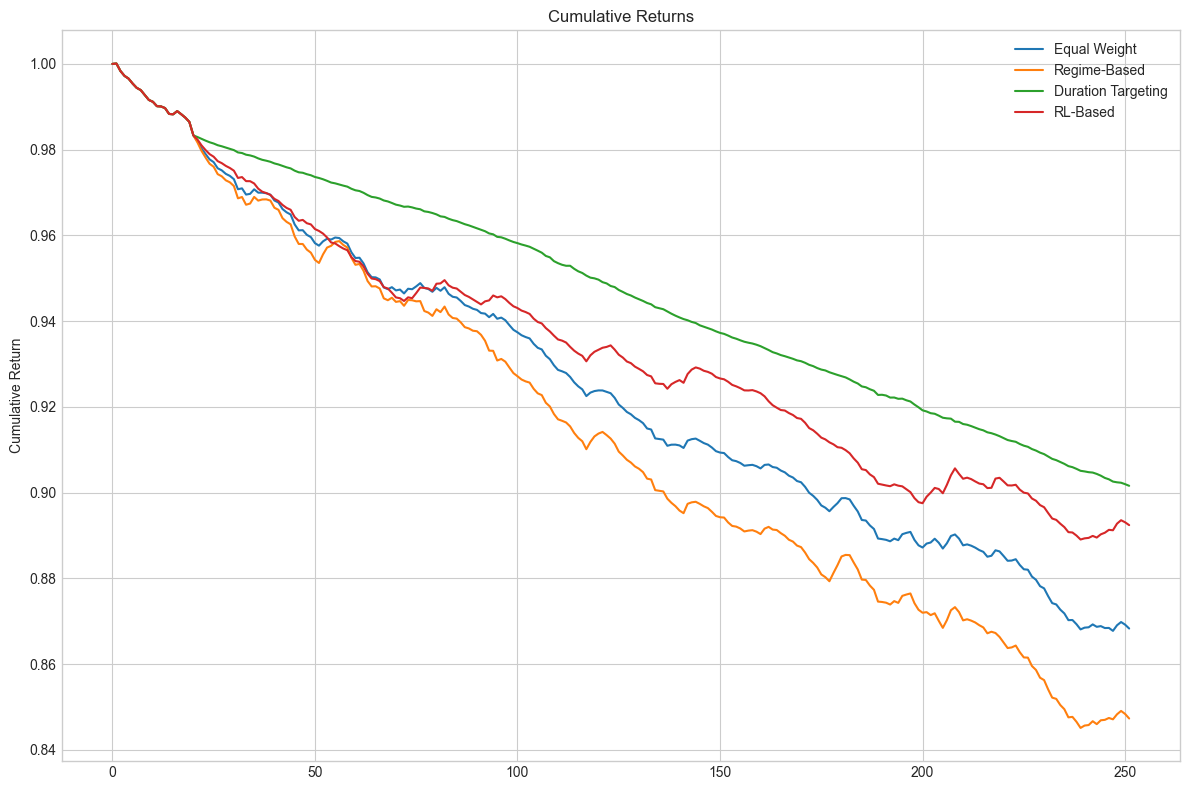

In [48]:
# Plot comparison
fig, ax = plt.subplots(figsize=(12, 8))
metrics_df.T.plot(kind='bar', ax=ax)
ax.set_title('Strategy Comparison')
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot cumulative returns
fig, ax = plt.subplots(figsize=(12, 8))
(1 + all_returns).cumprod().plot(ax=ax)
ax.set_title('Cumulative Returns')
ax.grid(True)
ax.set_ylabel('Cumulative Return')
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we've demonstrated the complete workflow for our fixed income RL project:

1. **Data Loading and Processing**: We loaded or generated synthetic fixed income data and processed it for our models.
2. **Regime Detection**: We used unsupervised learning to identify distinct market regimes and analyzed their characteristics.
3. **Bond Market Simulation**: We created a synthetic bond universe and simulated market dynamics with regime-dependent behavior.
4. **GNN for Credit Risk**: We modeled credit risk propagation through issuer networks using a graph neural network.
5. **RL Environment Setup**: We created a reinforcement learning environment for fixed income portfolio management.
6. **RL Agent Training**: We trained a TD3 agent to optimize portfolio allocation based on market conditions.

The regime-aware RL approach shows promising results for fixed income portfolio management, demonstrating the ability to adapt to changing market conditions and optimize risk-adjusted returns.